# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


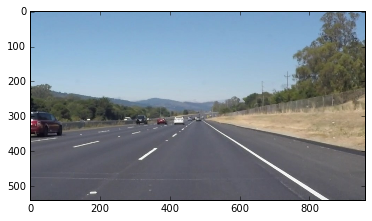

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
left_line_prev = np.zeros(4)
right_line_prev = np.zeros(4)

In [68]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    # separate lines into left and right
    """
    global left_line_prev
    global right_line_prev
    left_lines = []
    right_lines = []
    ymin = img.shape[0]
    ymax = img.shape[0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ymin > min(y1, y2):
                ymin = min(y1, y2)
            slope = (y2-y1)/(x2-x1)
            if not abs(slope) > 0.5:
                continue
            if slope < 0:
                left_lines.append(line)
            elif slope > 0:
                right_lines.append(line)
    ymin = img.shape[0]*0.6
    
    # left line parameters
    if left_lines:
        left_line = np.zeros(4)
        for line in left_lines:
            left_line += line[0]
        left_line /= len(left_lines)
        left_line_slope = (left_line[3]-left_line[1])/(left_line[2]-left_line[0])
        left_line_intercept = left_line[1] - (left_line[0]*left_line_slope)

        current_line = np.array(((ymax-left_line_intercept)/left_line_slope,
                                                   ymax,
                                                   (ymin-left_line_intercept)/left_line_slope,
                                                   ymin))
        print(left_line_prev)
        print(current_line)
        (lx1, ly1, lx2, ly2) = (left_line_prev*0.4 + current_line*0.6).astype(int)
        left_line_prev = np.array((lx1, ly1, lx2, ly2)).astype(float)
        cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)
    
    # right line parameters
    if right_lines:
        right_line = np.zeros(4)
        for line in right_lines:
            right_line += line[0]
        right_line /= len(right_lines)
        right_line_slope = (right_line[3]-right_line[1])/(right_line[2]-right_line[0])
        right_line_intercept = right_line[1] - (right_line[0]*right_line_slope)

        current_line = np.array(((ymax-right_line_intercept)/right_line_slope,
                                                   ymax,
                                                   (ymin-right_line_intercept)/right_line_slope,
                                                   ymin))
        (rx1, ry1, rx2, ry2) = (right_line_prev*0.4 + current_line*0.6).astype(int)
        right_line_prev = np.array((rx1, ry1, rx2, ry2)).astype(float)
        cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)
    
    #cv2.line(img, (200, 520), (int(left_line[2]), int(left_line[3])), color, thickness)
    #cv2.line(img, (int(right_line[0]), int(right_line[1])), (int(right_line[2]), int(right_line[3])), color, thickness)
            
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [53]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [69]:
def identify_line(image):
    imshape = image.shape
    gray_img = grayscale(image)
    
    # Canny transform
    thresholds = [50, 150]
    canny_img = canny(gray_img, thresholds[0], thresholds[1])
    
    kernel_size = 5
    blur_img = gaussian_blur(canny_img, kernel_size)
    
    # Mask image
    vertices = np.array([[(imshape[1]*0.15, imshape[0]), (imshape[1]*0.45, imshape[0]*0.6), (imshape[1]*0.55, imshape[0]*0.6), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_img = region_of_interest(blur_img, vertices)
    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    output_img = weighted_img(line_img, image)
    
    return output_img

[ 0.  0.  0.  0.]
[ 185.13  540.    457.29  324.  ]


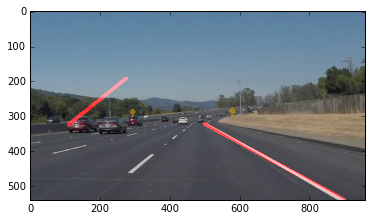

In [73]:
left_line_prev = np.zeros(4)
test_img = mpimg.imread('test_images/solidWhiteCurve.jpg')
tested_img = identify_line(test_img)
plt.imshow(tested_img, cmap='gray')

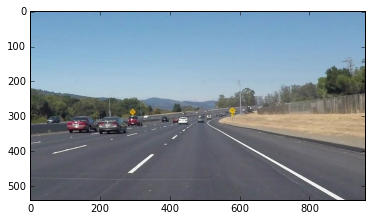

In [202]:
original_img = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(original_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = identify_line(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [71]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[ 111.  324.  274.  194.]
[ 157.50467183  540.          453.4463309   324.        ]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:04, 43.66it/s]

[ 138.  453.  381.  272.]
[ 157.50467183  540.          453.4463309   324.        ]
[ 149.  505.  424.  303.]
[ 160.17701025  540.          444.63405779  324.        ]
[ 155.  526.  436.  315.]
[ 156.16363934  540.          454.30796924  324.        ]
[ 155.  534.  446.  320.]
[ 157.63818945  540.          450.55905276  324.        ]
[ 156.  537.  448.  322.]
[ 152.66666667  540.          452.66666667  324.        ]
[ 153.  538.  450.  323.]
[ 139.65217391  540.          455.43478261  324.        ]
[ 144.  539.  453.  323.]
[ 151.29064685  540.          451.12281469  324.        ]
[ 148.  539.  451.  323.]
[ 154.30580313  540.          454.54109725  324.        ]
[ 151.  539.  453.  323.]
[ 154.30467163  540.          457.31888964  324.        ]
[ 152.  539.  455.  323.]
[ 158.78081485  540.          453.2790098   324.        ]


  8%|▊         | 17/222 [00:00<00:04, 48.55it/s]

[ 156.  539.  453.  323.]
[ 155.128982   540.         453.7810368  324.       ]
[ 155.  539.  453.  323.]
[ 153.54368932  540.          455.52427184  324.        ]
[ 154.  539.  454.  323.]
[ 152.82608071  540.          447.99195749  324.        ]
[ 153.  539.  450.  323.]
[ 154.68674136  540.          447.62791783  324.        ]
[ 154.  539.  448.  323.]
[ 126.20080321  540.          459.30923695  324.        ]
[ 137.  539.  454.  323.]
[ 141.16734694  540.          453.85306122  324.        ]
[ 139.  539.  453.  323.]
[ 152.2652214   540.          453.54935424  324.        ]
[ 146.  539.  453.  323.]
[ 153.773  540.     455.633  324.   ]


 11%|█         | 24/222 [00:00<00:03, 52.60it/s]

[ 150.  539.  454.  323.]
[ 147.699117    540.          456.20242826  324.        ]
[ 148.  539.  455.  323.]
[ 152.13475177  540.          450.85815603  324.        ]


 14%|█▎        | 30/222 [00:00<00:03, 53.19it/s]

[ 150.  539.  452.  323.]
[ 150.9315  540.      453.5475  324.    ]
[ 150.  539.  452.  323.]
[ 158.25227164  540.          447.13032042  324.        ]
[ 154.  539.  449.  323.]
[ 153.52280278  540.          459.22379946  324.        ]
[ 153.  539.  455.  323.]
[ 154.609375    540.          456.43080357  324.        ]
[ 153.  539.  455.  323.]
[ 131.5  540.   455.5  324. ]
[ 140.  539.  455.  323.]
[ 137.73684211  540.          456.05263158  324.        ]
[ 138.  539.  455.  323.]
[ 148.61360544  540.          453.0707483   324.        ]
[ 144.  539.  453.  323.]
[ 148.71576227  540.          453.69915098  324.        ]
[ 146.  539.  453.  323.]
[ 153.34307458  540.          449.82526636  324.        ]
[ 150.  539.  451.  323.]
[ 154.0710466   540.          451.75171887  324.        ]
[ 152.  539.  451.  323.]
[ 155.64213564  540.          451.18499278  324.        ]


 19%|█▉        | 42/222 [00:00<00:03, 54.00it/s]

[ 154.  539.  451.  323.]
[ 156.38616601  540.          451.35849802  324.        ]
[ 155.  539.  451.  323.]
[ 152.85358408  540.          456.05544022  324.        ]
[ 153.  539.  454.  323.]
[ 156.82474774  540.          448.03664365  324.        ]
[ 155.  539.  450.  323.]
[ 153.88022426  540.          449.64169215  324.        ]
[ 154.  539.  449.  323.]
[ 152.06896552  540.          450.          324.        ]
[ 152.  539.  449.  323.]
[ 142.79065041  540.          450.10772358  324.        ]
[ 146.  539.  449.  323.]
[ 153.25864055  540.          448.51670507  324.        ]
[ 150.  539.  448.  323.]
[ 150.48285124  540.          448.46466942  324.        ]
[ 150.  539.  448.  323.]
[ 153.3249354   540.          445.51098191  324.        ]


 24%|██▍       | 53/222 [00:00<00:03, 49.70it/s]

[ 151.  539.  446.  323.]
[ 147.78807811  540.          451.74203494  324.        ]
[ 149.  539.  449.  323.]
[ 151.03835508  540.          448.26255437  324.        ]
[ 150.  539.  448.  323.]
[ 154.29475834  540.          443.88767869  324.        ]
[ 152.  539.  445.  323.]
[ 153.76825397  540.          449.9968254   324.        ]
[ 153.  539.  447.  323.]
[ 156.78835979  540.          443.64550265  324.        ]
[ 155.  539.  444.  323.]
[ 150.06896552  540.          448.          324.        ]
[ 152.  539.  446.  323.]
[ 119.42329545  540.          458.15056818  324.        ]
[ 132.  539.  453.  323.]
[ 143.441505    540.          450.99706055  324.        ]
[ 138.  539.  451.  323.]
[ 135.13237822  540.          455.72836676  324.        ]


 29%|██▉       | 65/222 [00:01<00:03, 51.65it/s]

[ 136.  539.  453.  323.]
[ 141.93325897  540.          454.2277375   324.        ]
[ 139.  539.  453.  323.]
[ 144.40274914  540.          452.59243986  324.        ]
[ 142.  539.  452.  323.]
[ 147.09658762  540.          454.91844997  324.        ]
[ 145.  539.  453.  323.]
[ 145.68636364  540.          454.95909091  324.        ]
[ 145.  539.  454.  323.]
[ 149.42619627  540.          452.66707218  324.        ]
[ 147.  539.  453.  323.]
[ 148.24334975  540.          451.38817734  324.        ]
[ 147.  539.  452.  323.]
[ 143.42857143  540.          452.          324.        ]
[ 144.  539.  452.  323.]
[ 146.62068966  540.          452.          324.        ]
[ 145.  539.  452.  323.]
[ 117.54464286  540.          453.11607143  324.        ]
[ 128.  539.  452.  323.]
[ 134.14362416  540.          447.27114094  324.        ]
[ 131.  539.  449.  323.]
[ 133.16457529  540.          451.74372587  324.        ]


 35%|███▍      | 77/222 [00:01<00:02, 51.40it/s]

[ 132.  539.  450.  323.]
[ 132.48664344  540.          452.09639954  324.        ]
[ 132.  539.  451.  323.]
[ 142.70831419  540.          446.91410198  324.        ]
[ 138.  539.  448.  323.]
[ 140.35341365  540.          448.30522088  324.        ]
[ 139.  539.  448.  323.]
[ 142.43685897  540.          450.92916667  324.        ]
[ 141.  539.  449.  323.]
[ 141.21687371  540.          453.36594203  324.        ]
[ 141.  539.  451.  323.]
[ 143.44318718  540.          449.97784064  324.        ]
[ 142.  539.  450.  323.]
[ 142.74431818  540.          449.5625      324.        ]
[ 142.  539.  449.  323.]
[ 118.28571429  540.          450.          324.        ]
[ 127.  539.  449.  323.]
[ 101.18666667  540.          458.30666667  324.        ]
[ 111.  539.  454.  323.]
[ 130.97435897  540.          446.66666667  324.        ]


 37%|███▋      | 83/222 [00:01<00:02, 50.59it/s]

[ 122.  539.  449.  323.]
[ 138.64390244  540.          444.20487805  324.        ]
[ 131.  539.  446.  323.]
[ 139.12857143  540.          445.68241758  324.        ]
[ 135.  539.  445.  323.]
[ 137.08187135  540.          447.81871345  324.        ]
[ 136.  539.  446.  323.]
[ 140.2         540.          448.08571429  324.        ]
[ 138.  539.  447.  323.]
[ 140.62900188  540.          445.71374765  324.        ]
[ 139.  539.  446.  323.]
[ 139.98076923  540.          447.36538462  324.        ]
[ 139.  539.  446.  323.]
[ 142.52475248  540.          444.06930693  324.        ]
[ 141.  539.  444.  323.]
[ 142.2  540.   444.6  324. ]


 40%|████      | 89/222 [00:01<00:02, 51.67it/s]

[ 141.  539.  444.  323.]
[ 139.17241379  540.          452.          324.        ]
[ 139.  539.  448.  323.]
[ 109.54583333  540.          457.84583333  324.        ]


 43%|████▎     | 95/222 [00:01<00:02, 47.34it/s]

[ 121.  539.  453.  323.]
[ 130.36351351  540.          452.90405405  324.        ]
[ 126.  539.  452.  323.]
[ 135.40909091  540.          449.59090909  324.        ]
[ 131.  539.  450.  323.]
[ 131.93792867  540.          455.271262    324.        ]
[ 131.  539.  453.  323.]
[ 133.2943892   540.          452.99893466  324.        ]
[ 132.  539.  452.  323.]
[ 141.99063232  540.          446.51522248  324.        ]
[ 137.  539.  448.  323.]
[ 139.23468635  540.          450.8804428   324.        ]
[ 138.  539.  449.  323.]
[ 143.37337884  540.          444.15153584  324.        ]
[ 141.  539.  446.  323.]
[ 138.16129032  540.          451.70967742  324.        ]


 45%|████▌     | 101/222 [00:01<00:02, 49.27it/s]

[ 139.  539.  449.  323.]
[ 141.6  540.   444.   324. ]
[ 140.  539.  446.  323.]
[ 107.4  540.   453.   324. ]


 48%|████▊     | 106/222 [00:02<00:02, 49.36it/s]

[ 120.  539.  450.  323.]
[ 118.29437229  540.          460.52813853  324.        ]
[ 118.  539.  456.  323.]
[ 138.52247191  540.          451.6011236   324.        ]
[ 130.  539.  453.  323.]
[ 127.49278997  540.          460.6338558   324.        ]
[ 128.  539.  457.  323.]
[ 133.58295019  540.          457.33467433  324.        ]
[ 131.  539.  457.  323.]
[ 143.27061368  540.          453.34360638  324.        ]
[ 138.  539.  454.  323.]
[ 140.83924184  540.          453.58055458  324.        ]
[ 139.  539.  453.  323.]
[ 142.98807947  540.          456.61721854  324.        ]
[ 141.  539.  455.  323.]
[ 145.91969481  540.          456.24686409  324.        ]


 50%|█████     | 112/222 [00:02<00:02, 51.06it/s]

[ 143.  539.  455.  323.]
[ 148.06422629  540.          456.07088186  324.        ]
[ 146.  539.  455.  323.]
[ 149.93333333  540.          455.93333333  324.        ]
[ 148.  539.  455.  323.]
[ 147.44327731  540.          459.64495798  324.        ]
[ 147.  539.  457.  323.]
[ 106.  540.  458.  324.]


 53%|█████▎    | 118/222 [00:02<00:01, 52.77it/s]

[ 122.  539.  457.  323.]
[ 126.70325203  540.          455.97154472  324.        ]
[ 124.  539.  456.  323.]
[ 121.          540.          455.73684211  324.        ]
[ 122.  539.  455.  323.]
[ 137.01568441  540.          452.39211027  324.        ]
[ 131.  539.  453.  323.]
[ 136.556231    540.          453.00607903  324.        ]
[ 134.  539.  453.  323.]
[ 141.33165468  540.          450.56906475  324.        ]
[ 138.  539.  451.  323.]
[ 141.84173642  540.          454.04730387  324.        ]
[ 140.  539.  452.  323.]
[ 144.3117338   540.          456.01751313  324.        ]
[ 142.  539.  454.  323.]
[ 142.37871932  540.          459.37419443  324.        ]


 56%|█████▌    | 124/222 [00:02<00:01, 53.46it/s]

[ 142.  539.  457.  323.]
[ 145.91068673  540.          459.03568673  324.        ]
[ 144.  539.  458.  323.]
[ 148.18797348  540.          456.84706439  324.        ]
[ 146.  539.  457.  323.]
[ 147.52861446  540.          460.68524096  324.        ]
[ 146.  539.  459.  323.]
[ 150.39655172  540.          459.5         324.        ]


 59%|█████▊    | 130/222 [00:02<00:01, 54.28it/s]

[ 148.  539.  459.  323.]
[ 140.39631783  540.          458.11724806  324.        ]
[ 143.  539.  458.  323.]
[ 151.8881323   540.          456.13715953  324.        ]
[ 148.  539.  456.  323.]
[ 146.89490816  540.          461.77981865  324.        ]
[ 147.  539.  459.  323.]
[ 152.10722611  540.          457.64568765  324.        ]
[ 150.  539.  458.  323.]
[ 152.25721021  540.          457.02925679  324.        ]
[ 151.  539.  457.  323.]
[ 154.60400314  540.          457.94073783  324.        ]
[ 153.  539.  457.  323.]
[ 154.26009412  540.          455.10489412  324.        ]


 61%|██████▏   | 136/222 [00:02<00:01, 54.28it/s]

[ 153.  539.  455.  323.]
[ 150.79978587  540.          456.76124197  324.        ]
[ 151.  539.  456.  323.]
[ 152.49310396  540.          455.52736171  324.        ]
[ 151.  539.  455.  323.]
[ 156.42032086  540.          454.43101604  324.        ]
[ 154.  539.  454.  323.]
[ 148.05263158  540.          455.          324.        ]


 64%|██████▍   | 142/222 [00:02<00:01, 53.66it/s]

[ 150.  539.  454.  323.]
[ 152.96590909  540.          454.875       324.        ]
[ 151.  539.  454.  323.]
[ 145.37247228  540.          460.98891063  324.        ]
[ 147.  539.  458.  323.]
[ 153.3699187   540.          459.58943089  324.        ]
[ 150.  539.  458.  323.]
[ 153.82  540.    463.42  324.  ]
[ 152.  539.  461.  323.]
[ 153.8254745   540.          462.45180902  324.        ]
[ 153.  539.  461.  323.]
[ 159.48785997  540.          458.30208922  324.        ]


 67%|██████▋   | 148/222 [00:02<00:01, 51.03it/s]

[ 156.  539.  459.  323.]
[ 159.20347782  540.          459.38631663  324.        ]
[ 157.  539.  459.  323.]
[ 158.70434783  540.          454.53043478  324.        ]
[ 158.  539.  456.  323.]
[ 157.88533026  540.          455.25860215  324.        ]
[ 157.  539.  455.  323.]
[ 157.68759812  540.          455.23861852  324.        ]


 69%|██████▉   | 154/222 [00:02<00:01, 51.03it/s]

[ 157.  539.  455.  323.]
[ 157.61864407  540.          461.48305085  324.        ]
[ 157.  539.  458.  323.]
[ 163.93050783  540.          457.12638412  324.        ]
[ 161.  539.  457.  323.]
[ 156.71934605  540.          459.82561308  324.        ]
[ 158.  539.  458.  323.]
[ 160.63199746  540.          460.31138677  324.        ]


 72%|███████▏  | 160/222 [00:03<00:01, 51.10it/s]

[ 159.  539.  459.  323.]
[ 164.83214286  540.          454.11785714  324.        ]
[ 162.  539.  456.  323.]
[ 160.72044818  540.          458.14181673  324.        ]
[ 161.  539.  457.  323.]
[ 162.87434053  540.          457.34916067  324.        ]
[ 162.  539.  457.  323.]
[ 162.43808574  540.          456.78384845  324.        ]
[ 162.  539.  456.  323.]
[ 165.2733462   540.          458.88497104  324.        ]
[ 163.  539.  457.  323.]
[ 165.26746988  540.          460.38072289  324.        ]
[ 164.  539.  459.  323.]
[ 154.42857143  540.          463.          324.        ]


 75%|███████▍  | 166/222 [00:03<00:01, 51.15it/s]

[ 158.  539.  461.  323.]
[ 161.79661017  540.          462.          324.        ]
[ 160.  539.  461.  323.]
[ 166.50561798  540.          462.59550562  324.        ]
[ 163.  539.  461.  323.]
[ 166.02941176  540.          465.88823529  324.        ]
[ 164.  539.  463.  323.]
[ 178.80718954  540.          461.5130719   324.        ]


 77%|███████▋  | 172/222 [00:03<00:00, 50.46it/s]

[ 172.  539.  462.  323.]
[ 177.94623656  540.          464.55268817  324.        ]
[ 175.  539.  463.  323.]
[ 178.90948005  540.          461.72453733  324.        ]
[ 177.  539.  462.  323.]
[ 180.52395965  540.          458.78625473  324.        ]
[ 179.  539.  460.  323.]
[ 181.15978774  540.          458.03714623  324.        ]
[ 180.  539.  458.  323.]
[ 183.85178056  540.          456.60635226  324.        ]
[ 182.  539.  457.  323.]
[ 183.03586329  540.          460.87341323  324.        ]
[ 182.  539.  459.  323.]
[ 180.98386096  540.          460.93916822  324.        ]
[ 181.  539.  460.  323.]
[ 155.42857143  540.          464.          324.        ]
[ 165.  539.  462.  323.]
[ 180.375  540.     460.5    324.   ]
[ 174.  539.  461.  323.]
[ 176.98481013  540.          464.07341772  324.        ]


 80%|████████  | 178/222 [00:03<00:00, 50.07it/s]

[ 175.  539.  462.  323.]
[ 177.02173913  540.          461.10869565  324.        ]
[ 176.  539.  461.  323.]
[ 180.19465978  540.          463.17140396  324.        ]
[ 178.  539.  462.  323.]
[ 187.25        540.          458.68726236  324.        ]
[ 183.  539.  460.  323.]
[ 189.08428826  540.          459.84059078  324.        ]
[ 186.  539.  459.  323.]
[ 188.94175313  540.          455.9780322   324.        ]
[ 187.  539.  457.  323.]
[ 186.80536246  540.          462.22144985  324.        ]


 83%|████████▎ | 184/222 [00:03<00:00, 49.78it/s]

[ 186.  539.  460.  323.]
[ 187.39136041  540.          457.00838169  324.        ]
[ 186.  539.  458.  323.]
[ 186.28753128  540.          457.27835696  324.        ]


 85%|████████▌ | 189/222 [00:03<00:00, 49.10it/s]

[ 186.  539.  457.  323.]
[ 178.30429448  540.          453.93619632  324.        ]
[ 181.  539.  455.  323.]
[ 183.82606325  540.          450.11613959  324.        ]
[ 182.  539.  452.  323.]
[ 181.15167549  540.          452.00881834  324.        ]
[ 181.  539.  452.  323.]
[ 181.46666667  540.          455.06666667  324.        ]
[ 181.  539.  453.  323.]
[ 186.71403509  540.          459.80877193  324.        ]


 87%|████████▋ | 194/222 [00:03<00:00, 48.87it/s]

[ 184.  539.  457.  323.]
[ 187.5680758   540.          461.31501458  324.        ]
[ 186.  539.  459.  323.]
[ 186.1014455   540.          461.17163693  324.        ]
[ 186.  539.  460.  323.]
[ 186.45150721  540.          458.7870249   324.        ]
[ 186.  539.  459.  323.]
[ 183.94656759  540.          462.31599434  324.        ]


 90%|████████▉ | 199/222 [00:03<00:00, 48.26it/s]

[ 184.  539.  460.  323.]
[ 182.25  540.    459.    324.  ]
[ 182.  539.  459.  323.]
[ 181.00740741  540.          455.67407407  324.        ]
[ 181.  539.  457.  323.]
[ 186.84534535  540.          451.49399399  324.        ]
[ 184.  539.  453.  323.]
[ 182.95417889  540.          459.13013196  324.        ]


 94%|█████████▍| 209/222 [00:04<00:00, 46.77it/s]

[ 183.  539.  456.  323.]
[ 184.05867182  540.          455.59058672  324.        ]
[ 183.  539.  455.  323.]
[ 186.32080902  540.          453.73737845  324.        ]
[ 184.  539.  454.  323.]
[ 184.93320048  540.          454.20573934  324.        ]
[ 184.  539.  454.  323.]
[ 183.69580247  540.          454.09580247  324.        ]
[ 183.  539.  454.  323.]
[ 182.76438306  540.          459.63477545  324.        ]
[ 182.  539.  457.  323.]
[ 185.23094823  540.          453.81733566  324.        ]
[ 183.  539.  455.  323.]
[ 162.56554307  540.          461.082397    324.        ]
[ 170.  539.  458.  323.]
[ 178.05  540.    458.85  324.  ]


100%|█████████▉| 221/222 [00:04<00:00, 51.01it/s]

[ 174.  539.  458.  323.]
[ 180.48616601  540.          460.51778656  324.        ]
[ 177.  539.  459.  323.]
[ 175.05129516  540.          466.1433197   324.        ]
[ 175.  539.  463.  323.]
[ 183.65882353  540.          459.37647059  324.        ]
[ 180.  539.  460.  323.]
[ 182.24444444  540.          463.04444444  324.        ]
[ 181.  539.  461.  323.]
[ 185.55578886  540.          458.05972587  324.        ]
[ 183.  539.  459.  323.]
[ 184.51319483  540.          456.28691746  324.        ]
[ 183.  539.  457.  323.]
[ 181.41219944  540.          459.96159051  324.        ]
[ 182.  539.  458.  323.]
[ 181.80362694  540.          457.11968912  324.        ]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.82 s, sys: 932 ms, total: 4.75 s
Wall time: 4.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [74]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[ 111.  324.  274.  194.]
[ 132.71517672  540.          453.57172557  324.        ]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 6/682 [00:00<00:13, 51.09it/s]

[ 124.  453.  381.  272.]
[ 132.71517672  540.          453.57172557  324.        ]
[ 129.  505.  424.  303.]
[ 133.87405542  540.          455.24433249  324.        ]
[ 131.  526.  442.  315.]
[ 134.91404612  540.          454.15932914  324.        ]
[ 133.  534.  449.  320.]
[ 129.25558644  540.          460.73574208  324.        ]
[ 130.  537.  456.  322.]
[ 128.00925486  540.          460.97935453  324.        ]
[ 128.  538.  458.  323.]
[ 137.33530482  540.          457.89581438  324.        ]
[ 133.  539.  457.  323.]
[ 138.37654505  540.          458.50023362  324.        ]
[ 136.  539.  457.  323.]
[ 140.97095268  540.          454.72079555  324.        ]
[ 138.  539.  455.  323.]
[ 131.66819416  540.          463.3667685   324.        ]
[ 134.  539.  460.  323.]
[ 143.88254505  540.          452.41227477  324.        ]
[ 139.  539.  455.  323.]
[ 141.38083021  540.          455.63780124  324.        ]
[ 140.  539.  455.  323.]
[ 144.50998448  540.          453.25700983  324.  

  3%|▎         | 21/682 [00:00<00:11, 58.36it/s]

[ 148.  539.  451.  323.]
[ 152.52217623  540.          450.43228859  324.        ]
[ 150.  539.  450.  323.]
[ 146.49320334  540.          455.19181231  324.        ]
[ 147.  539.  453.  323.]
[ 151.70153257  540.          452.15352196  324.        ]
[ 149.  539.  452.  323.]
[ 148.71402669  540.          453.88633594  324.        ]
[ 148.  539.  453.  323.]
[ 154.38693655  540.          449.81981205  324.        ]
[ 151.  539.  451.  323.]
[ 143.96248119  540.          456.6966838   324.        ]
[ 146.  539.  454.  323.]
[ 151.40045499  540.          448.89184702  324.        ]
[ 149.  539.  450.  323.]
[ 144.44159289  540.          454.33986243  324.        ]
[ 146.  539.  452.  323.]
[ 139.23479682  540.          461.93044899  324.        ]
[ 141.  539.  457.  323.]
[ 150.03794604  540.          447.81340296  324.        ]
[ 146.  539.  451.  323.]
[ 148.53279786  540.          450.41231593  324.        ]
[ 147.  539.  450.  323.]
[ 146.77456736  540.          452.12859258  324.  

  5%|▌         | 35/682 [00:00<00:10, 61.08it/s]

[ 146.  539.  458.  323.]
[ 158.92543343  540.          446.6038613   324.        ]
[ 153.  539.  451.  323.]
[ 158.2495021   540.          446.13629455  324.        ]
[ 156.  539.  448.  323.]
[ 158.26080301  540.          446.35744731  324.        ]
[ 157.  539.  447.  323.]
[ 153.21571434  540.          451.71430324  324.        ]
[ 154.  539.  449.  323.]
[ 158.59976849  540.          447.20328903  324.        ]
[ 156.  539.  447.  323.]
[ 153.1468386   540.          455.49292845  324.        ]
[ 154.  539.  452.  323.]
[ 152.57833219  540.          455.18503076  324.        ]
[ 153.  539.  453.  323.]
[ 154.65990901  540.          450.96384388  324.        ]
[ 153.  539.  451.  323.]
[ 162.20093339  540.          446.1075944   324.        ]
[ 158.  539.  448.  323.]
[ 151.72606061  540.          454.91151515  324.        ]
[ 154.  539.  452.  323.]
[ 162.30787164  540.          445.37095447  324.        ]
[ 158.  539.  448.  323.]
[ 150.44137615  540.          453.61184483  324.  

  7%|▋         | 48/682 [00:00<00:10, 59.78it/s]

[ 152.  539.  450.  323.]
[ 155.86936716  540.          447.79099726  324.        ]
[ 154.  539.  448.  323.]
[ 154.62644877  540.          446.84079337  324.        ]
[ 154.  539.  447.  323.]
[ 160.72529481  540.          438.93622239  324.        ]
[ 158.  539.  442.  323.]
[ 145.53671734  540.          454.9799781   324.        ]
[ 150.  539.  449.  323.]
[ 152.59287107  540.          452.11668059  324.        ]
[ 151.  539.  450.  323.]
[ 153.2181146   540.          450.26802218  324.        ]
[ 152.  539.  450.  323.]
[ 155.10414866  540.          447.55358686  324.        ]
[ 153.  539.  448.  323.]
[ 153.06251985  540.          450.20584366  324.        ]
[ 153.  539.  449.  323.]
[ 160.7619613   540.          442.11288478  324.        ]
[ 157.  539.  444.  323.]
[ 148.80178122  540.          454.20681328  324.        ]
[ 152.  539.  450.  323.]
[ 149.75049003  540.          453.09189438  324.        ]
[ 150.  539.  451.  323.]
[ 168.73277944  540.          436.26519177  324.  

  8%|▊         | 54/682 [00:00<00:11, 55.33it/s]

[ 161.  539.  442.  323.]
[ 154.5560054   540.          446.34547908  324.        ]
[ 157.  539.  444.  323.]
[ 148.10916764  540.          455.7146565   324.        ]
[ 151.  539.  451.  323.]
[ 149.34944769  540.          450.82989947  324.        ]
[ 150.  539.  450.  323.]
[ 150.43452632  540.          449.92421053  324.        ]
[ 150.  539.  449.  323.]
[ 157.02635577  540.          439.77530388  324.        ]
[ 154.  539.  443.  323.]
[ 149.5884796   540.          453.70292353  324.        ]
[ 151.  539.  449.  323.]
[ 159.39074159  540.          440.41769453  324.        ]


  9%|▉         | 60/682 [00:01<00:12, 51.09it/s]

[ 156.  539.  443.  323.]
[ 159.86177074  540.          438.78103196  324.        ]
[ 158.  539.  440.  323.]
[ 151.8252131   540.          449.03113504  324.        ]


 10%|▉         | 66/682 [00:01<00:12, 48.06it/s]

[ 154.  539.  445.  323.]
[ 147.62606049  540.          449.42577299  324.        ]
[ 150.  539.  447.  323.]
[ 154.16273513  540.          441.82746155  324.        ]
[ 152.  539.  443.  323.]
[ 146.62145467  540.          450.49477989  324.        ]
[ 148.  539.  447.  323.]
[ 143.66918462  540.          457.14897737  324.        ]
[ 145.  539.  453.  323.]
[ 147.54802843  540.          451.39397066  324.        ]
[ 146.  539.  452.  323.]
[ 148.20786241  540.          449.86486486  324.        ]
[ 147.  539.  450.  323.]
[ 150.54532235  540.          448.00339312  324.        ]
[ 149.  539.  448.  323.]
[ 149.04254062  540.          454.27149188  324.        ]
[ 149.  539.  451.  323.]
[ 157.58903622  540.          444.17299991  324.        ]


 10%|█         | 71/682 [00:01<00:12, 47.67it/s]

[ 154.  539.  446.  323.]
[ 158.39946919  540.          440.62008027  324.        ]


 11%|█         | 76/682 [00:01<00:14, 42.58it/s]

[ 156.  539.  442.  323.]
[ 148.89581016  540.          450.43084909  324.        ]
[ 151.  539.  447.  323.]
[ 150.91506566  540.          448.47681865  324.        ]
[ 150.  539.  447.  323.]
[ 151.64913604  540.          449.28532831  324.        ]
[ 150.  539.  448.  323.]
[ 151.87522655  540.          452.4352628   324.        ]
[ 151.  539.  450.  323.]
[ 147.18387568  540.          455.45921986  324.        ]
[ 148.  539.  453.  323.]
[ 154.756572   540.         448.3067304  324.       ]
[ 152.  539.  450.  323.]
[ 149.74094545  540.          450.88250211  324.        ]


 12%|█▏        | 81/682 [00:01<00:14, 40.23it/s]

[ 150.  539.  450.  323.]
[ 151.56679483  540.          449.02198561  324.        ]
[ 150.  539.  449.  323.]
[ 149.72864759  540.          450.66216951  324.        ]
[ 149.  539.  449.  323.]
[ 155.10952994  540.          444.77667899  324.        ]
[ 152.  539.  446.  323.]
[ 155.24818049  540.          443.2874818   324.        ]
[ 153.  539.  444.  323.]
[ 150.18757758  540.          447.34978402  324.        ]
[ 151.  539.  446.  323.]
[ 157.21219862  540.          437.56581515  324.        ]
[ 154.  539.  440.  323.]
[ 148.99107143  540.          445.99107143  324.        ]
[ 150.  539.  443.  323.]
[ 150.16364832  540.          447.84627338  324.        ]
[ 150.  539.  445.  323.]
[ 153.69240219  540.          440.73717831  324.        ]


 13%|█▎        | 87/682 [00:01<00:13, 43.95it/s]

[ 152.  539.  442.  323.]
[ 142.24414766  540.          450.42662065  324.        ]
[ 146.  539.  447.  323.]
[ 148.50322581  540.          446.06007403  324.        ]


 14%|█▎        | 93/682 [00:01<00:12, 45.90it/s]

[ 147.  539.  446.  323.]
[ 146.17989418  540.          447.89417989  324.        ]
[ 146.  539.  447.  323.]
[ 149.73593267  540.          447.13550984  324.        ]
[ 148.  539.  447.  323.]
[ 144.24907888  540.          452.62444545  324.        ]
[ 145.  539.  450.  323.]
[ 151.76612452  540.          451.75405209  324.        ]
[ 149.  539.  451.  323.]
[ 154.27223994  540.          462.38862096  324.        ]
[ 152.  539.  457.  323.]
[ 158.89374913  540.          458.16541091  324.        ]
[ 156.  539.  457.  323.]
[ 153.13127753  540.          454.55859031  324.        ]
[ 154.  539.  455.  323.]
[ 151.65240775  540.          453.16085053  324.        ]
[ 152.  539.  453.  323.]
[ 153.90622547  540.          454.95923216  324.        ]


 15%|█▍        | 99/682 [00:01<00:12, 47.36it/s]

[ 153.  539.  454.  323.]
[ 148.70087589  540.          456.90513965  324.        ]
[ 150.  539.  455.  323.]
[ 150.22904448  540.          450.68652248  324.        ]


 15%|█▌        | 104/682 [00:02<00:12, 45.68it/s]

[ 150.  539.  452.  323.]
[ 146.99419081  540.          455.46439311  324.        ]
[ 148.  539.  454.  323.]
[ 146.69502133  540.          455.12789066  324.        ]
[ 147.  539.  454.  323.]
[ 151.0503465   540.          451.13766459  324.        ]
[ 149.  539.  452.  323.]
[ 144.11399747  540.          455.6769896   324.        ]
[ 146.  539.  454.  323.]
[ 145.96991656  540.          451.61418533  324.        ]
[ 145.  539.  452.  323.]
[ 152.1014869  540.         449.4647156  324.       ]
[ 149.  539.  450.  323.]
[ 144.57037037  540.          456.57037037  324.        ]
[ 146.  539.  453.  323.]
[ 139.34094185  540.          462.35487746  324.        ]


 16%|█▌        | 109/682 [00:02<00:12, 45.97it/s]

[ 142.  539.  458.  323.]
[ 142.19684842  540.          456.30990495  324.        ]
[ 142.  539.  456.  323.]
[ 151.57456369  540.          451.78136387  324.        ]


 17%|█▋        | 114/682 [00:02<00:12, 46.41it/s]

[ 147.  539.  453.  323.]
[ 147.68397175  540.          456.42138006  324.        ]
[ 147.  539.  455.  323.]
[ 143.88458818  540.          463.46900376  324.        ]
[ 145.  539.  460.  323.]
[ 144.57623626  540.          459.08173077  324.        ]
[ 144.  539.  459.  323.]
[ 152.1002204   540.          452.65034635  324.        ]
[ 148.  539.  455.  323.]
[ 152.94324818  540.          450.6330292   324.        ]
[ 150.  539.  452.  323.]
[ 152.10955166  540.          453.16218324  324.        ]
[ 151.  539.  452.  323.]
[ 152.37759724  540.          454.34102361  324.        ]
[ 151.  539.  453.  323.]
[ 147.77601381  540.          455.98991756  324.        ]


 17%|█▋        | 119/682 [00:02<00:11, 47.26it/s]

[ 149.  539.  454.  323.]
[ 148.92131432  540.          456.40253078  324.        ]
[ 148.  539.  455.  323.]
[ 149.21136019  540.          457.51754111  324.        ]


 18%|█▊        | 124/682 [00:02<00:11, 47.63it/s]

[ 148.  539.  456.  323.]
[ 144.45777351  540.          460.8915547   324.        ]
[ 145.  539.  458.  323.]
[ 161.93071332  540.          444.52530792  324.        ]
[ 155.  539.  449.  323.]
[ 153.30247456  540.          453.33111418  324.        ]
[ 153.  539.  451.  323.]
[ 152.52029922  540.          454.58735124  324.        ]
[ 152.  539.  453.  323.]
[ 153.91047745  540.          456.13859416  324.        ]
[ 153.  539.  454.  323.]
[ 152.84821302  540.          454.80833182  324.        ]
[ 152.  539.  454.  323.]
[ 155.28006213  540.          451.34256213  324.        ]
[ 153.  539.  452.  323.]
[ 151.80972636  540.          460.14490288  324.        ]
[ 152.  539.  456.  323.]
[ 163.4869697  540.         450.0469697  324.       ]


 19%|█▉        | 130/682 [00:02<00:10, 50.64it/s]

[ 158.  539.  452.  323.]
[ 152.98243088  540.          455.20823733  324.        ]
[ 154.  539.  453.  323.]
[ 149.28095782  540.          461.38858114  324.        ]
[ 151.  539.  458.  323.]


 20%|█▉        | 136/682 [00:02<00:10, 50.79it/s]

[ 147.81427473  540.          465.56217389  324.        ]
[ 149.  539.  462.  323.]
[ 154.04766785  540.          455.86871633  324.        ]
[ 152.  539.  458.  323.]
[ 154.10666667  540.          456.50666667  324.        ]
[ 153.  539.  457.  323.]
[ 148.27358834  540.          464.20801457  324.        ]
[ 150.  539.  461.  323.]
[ 154.31506397  540.          461.778539    324.        ]
[ 152.  539.  461.  323.]
[ 153.86314886  540.          456.78206778  324.        ]
[ 153.  539.  458.  323.]
[ 158.77390196  540.          450.08533429  324.        ]
[ 156.  539.  453.  323.]
[ 148.7008879   540.          463.53107658  324.        ]
[ 151.  539.  459.  323.]
[ 153.55  540.    455.95  324.  ]
[ 152.  539.  457.  323.]
[ 149.79063258  540.          458.22104389  324.        ]


 22%|██▏       | 147/682 [00:02<00:11, 46.78it/s]

[ 150.  539.  457.  323.]
[ 151.29670362  540.          459.9228677   324.        ]
[ 150.  539.  458.  323.]
[ 146.80326038  540.          464.1949531   324.        ]
[ 148.  539.  461.  323.]
[ 152.81866544  540.          454.80021525  324.        ]
[ 150.  539.  457.  323.]
[ 152.5532067  540.         460.9907067  324.       ]
[ 151.  539.  459.  323.]
[ 148.47542154  540.          465.71911902  324.        ]
[ 149.  539.  463.  323.]
[ 153.3353719   540.          455.28909091  324.        ]
[ 151.  539.  458.  323.]
[ 152.93762575  540.          456.0221328   324.        ]
[ 152.  539.  456.  323.]
[ 150.07494473  540.          465.06669542  324.        ]
[ 150.  539.  461.  323.]
[ 152.08746329  540.          460.23510278  324.        ]
[ 151.  539.  460.  323.]
[ 149.62778029  540.          463.82732882  324.        ]


 23%|██▎       | 158/682 [00:03<00:10, 49.22it/s]

[ 150.  539.  462.  323.]
[ 154.25332904  540.          456.72755584  324.        ]
[ 152.  539.  458.  323.]
[ 151.94186912  540.          460.16341294  324.        ]
[ 151.  539.  459.  323.]
[ 155.4116092   540.          457.90471264  324.        ]
[ 153.  539.  458.  323.]
[ 147.64812065  540.          473.10148492  324.        ]
[ 149.  539.  467.  323.]
[ 163.95536582  540.          454.17444121  324.        ]
[ 157.  539.  459.  323.]
[ 164.72855348  540.          452.41900919  324.        ]
[ 161.  539.  455.  323.]
[ 150.21707062  540.          478.35676398  324.        ]
[ 154.  539.  469.  323.]
[ 149.9160398   540.          480.04853191  324.        ]
[ 151.  539.  475.  323.]
[ 155.97346419  540.          477.91239549  324.        ]
[ 153.  539.  476.  323.]
[ 168.82293369  540.          457.44058075  324.        ]
[ 162.  539.  464.  323.]
[ 158.02526731  540.          473.85542837  324.        ]
[ 159.  539.  469.  323.]
[ 161.64765248  540.          470.72005265  324.  

 25%|██▍       | 170/682 [00:03<00:09, 51.28it/s]

[ 160.  539.  470.  323.]
[ 161.0483543   540.          469.42223394  324.        ]
[ 160.  539.  469.  323.]
[ 163.33172607  540.          465.18328857  324.        ]
[ 161.  539.  466.  323.]
[ 167.66337855  540.          458.8594328   324.        ]
[ 164.  539.  461.  323.]
[ 162.98892183  540.          465.50351069  324.        ]
[ 163.  539.  463.  323.]
[ 168.45169946  540.          463.47137746  324.        ]
[ 166.  539.  463.  323.]
[ 167.07563475  540.          463.71676063  324.        ]
[ 166.  539.  463.  323.]
[ 161.0400782   540.          472.45943304  324.        ]
[ 163.  539.  468.  323.]
[ 166.97231348  540.          469.04268228  324.        ]
[ 165.  539.  468.  323.]
[ 163.42960844  540.          477.33472821  324.        ]
[ 164.  539.  473.  323.]
[ 170.53043009  540.          462.83628229  324.        ]
[ 167.  539.  466.  323.]
[ 172.8265003   540.          461.91740939  324.        ]
[ 170.  539.  463.  323.]
[ 175.05576418  540.          461.70390537  324.  

 26%|██▌       | 176/682 [00:03<00:09, 53.30it/s]

[ 173.  539.  462.  323.]
[ 170.04804318  540.          462.75573549  324.        ]
[ 171.  539.  462.  323.]
[ 168.80080839  540.          472.07932298  324.        ]
[ 169.  539.  468.  323.]
[ 181.81687912  540.          457.72720879  324.        ]
[ 176.  539.  461.  323.]
[ 179.00908288  540.          459.58744108  324.        ]
[ 177.  539.  460.  323.]
[ 181.31355729  540.          461.6837995   324.        ]
[ 179.  539.  461.  323.]
[ 180.7928823   540.          462.13336487  324.        ]


 27%|██▋       | 182/682 [00:03<00:09, 51.76it/s]

[ 180.  539.  461.  323.]
[ 176.40826325  540.          469.52516821  324.        ]
[ 177.  539.  466.  323.]
[ 178.55275699  540.          465.07816069  324.        ]
[ 177.  539.  465.  323.]
[ 177.34805454  540.          470.42726246  324.        ]
[ 177.  539.  468.  323.]
[ 177.16463048  540.          470.26250636  324.        ]
[ 177.  539.  469.  323.]
[ 181.46864512  540.          462.98215863  324.        ]


 28%|██▊       | 188/682 [00:03<00:09, 51.10it/s]

[ 179.  539.  465.  323.]
[ 181.19000772  540.          462.35667438  324.        ]
[ 180.  539.  463.  323.]
[ 181.91669167  540.          462.82685251  324.        ]
[ 181.  539.  462.  323.]
[ 177.31669378  540.          469.49652792  324.        ]
[ 178.  539.  466.  323.]
[ 179.50134141  540.          461.52041932  324.        ]
[ 178.  539.  463.  323.]
[ 175.2117356   540.          469.10366982  324.        ]
[ 176.  539.  466.  323.]
[ 176.30204551  540.          469.45837738  324.        ]


 28%|██▊       | 194/682 [00:03<00:09, 49.97it/s]

[ 176.  539.  468.  323.]
[ 183.88517094  540.          452.30140236  324.        ]
[ 180.  539.  458.  323.]
[ 184.87412138  540.          453.90669467  324.        ]
[ 182.  539.  455.  323.]
[ 177.62777069  540.          460.48693115  324.        ]
[ 179.  539.  458.  323.]
[ 181.2213854   540.          452.62222222  324.        ]


 29%|██▉       | 200/682 [00:03<00:09, 49.23it/s]

[ 180.  539.  454.  323.]
[ 185.47674587  540.          446.27593451  324.        ]
[ 183.  539.  449.  323.]
[ 179.18763927  540.          457.19768035  324.        ]
[ 180.  539.  453.  323.]
[ 174.02933227  540.          461.113593    324.        ]
[ 176.  539.  457.  323.]
[ 184.26810527  540.          451.06284927  324.        ]
[ 180.  539.  453.  323.]
[ 176.37658882  540.          457.68104742  324.        ]


 30%|███       | 205/682 [00:04<00:10, 45.94it/s]

[ 177.  539.  455.  323.]
[ 166.60449902  540.          470.75853836  324.        ]
[ 170.  539.  464.  323.]
[ 170.03127942  540.          458.77068892  324.        ]
[ 170.  539.  460.  323.]
[ 171.11681034  540.          464.39267241  324.        ]
[ 170.  539.  462.  323.]
[ 175.48754787  540.          456.99502866  324.        ]


 31%|███       | 211/682 [00:04<00:09, 47.20it/s]

[ 173.  539.  458.  323.]
[ 176.49642406  540.          457.46907867  324.        ]
[ 175.  539.  457.  323.]
[ 171.68823084  540.          458.22266133  324.        ]
[ 173.  539.  457.  323.]
[ 177.23631855  540.          449.73816357  324.        ]
[ 175.  539.  452.  323.]
[ 169.08284642  540.          464.49863367  324.        ]
[ 171.  539.  459.  323.]
[ 162.363072    540.          467.64702262  324.        ]
[ 165.  539.  464.  323.]
[ 167.24747931  540.          459.2044355   324.        ]
[ 166.  539.  461.  323.]
[ 166.2599835   540.          458.44810231  324.        ]
[ 166.  539.  459.  323.]
[ 164.8931975  540.         457.8205718  324.       ]
[ 165.  539.  458.  323.]
[ 163.15129642  540.          467.02340411  324.        ]
[ 163.  539.  463.  323.]
[ 162.75365745  540.          467.58148974  324.        ]


 32%|███▏      | 216/682 [00:04<00:09, 47.76it/s]

[ 162.  539.  465.  323.]
[ 162.21180591  540.          466.16276914  324.        ]
[ 162.  539.  465.  323.]
[ 161.70444212  540.          460.76541188  324.        ]
[ 161.  539.  462.  323.]
[ 162.62968037  540.          454.08173516  324.        ]
[ 161.  539.  457.  323.]
[ 161.17030924  540.          457.68514417  324.        ]
[ 161.  539.  457.  323.]
[ 162.09981069  540.          453.97696676  324.        ]
[ 161.  539.  455.  323.]
[ 150.95423946  540.          466.43038863  324.        ]
[ 154.  539.  461.  323.]
[ 153.31605791  540.          466.12158605  324.        ]


 33%|███▎      | 222/682 [00:04<00:09, 48.82it/s]

[ 153.  539.  464.  323.]
[ 162.94758065  540.          455.59274194  324.        ]
[ 158.  539.  458.  323.]
[ 159.97202704  540.          457.309911    324.        ]
[ 159.  539.  457.  323.]
[ 160.34636519  540.          461.02630394  324.        ]


 34%|███▍      | 232/682 [00:04<00:09, 46.22it/s]

[ 159.  539.  459.  323.]
[ 160.91729363  540.          459.61008359  324.        ]
[ 160.  539.  459.  323.]
[ 157.44767889  540.          460.70082072  324.        ]
[ 158.  539.  460.  323.]
[ 153.32322581  540.          468.26516129  324.        ]
[ 155.  539.  464.  323.]
[ 165.78177481  540.          450.62146947  324.        ]
[ 161.  539.  455.  323.]
[ 162.16919463  540.          454.21382718  324.        ]
[ 161.  539.  454.  323.]
[ 163.77575758  540.          446.97575758  324.        ]
[ 162.  539.  449.  323.]
[ 156.53871123  540.          454.04206694  324.        ]
[ 158.  539.  452.  323.]
[ 155.38871482  540.          457.76991587  324.        ]
[ 156.  539.  455.  323.]
[ 151.14859438  540.          466.94099475  324.        ]


 35%|███▌      | 242/682 [00:04<00:09, 47.03it/s]

[ 153.  539.  462.  323.]
[ 156.41040898  540.          458.42321308  324.        ]
[ 155.  539.  459.  323.]
[ 154.57319811  540.          457.58658553  324.        ]
[ 154.  539.  458.  323.]
[ 155.58564321  540.          456.9724236   324.        ]
[ 154.  539.  457.  323.]
[ 153.82994488  540.          454.91813124  324.        ]
[ 153.  539.  455.  323.]
[ 150.64331498  540.          456.58156541  324.        ]
[ 151.  539.  455.  323.]
[ 152.03197366  540.          459.47342235  324.        ]
[ 151.  539.  457.  323.]
[ 153.13685799  540.          455.5195987   324.        ]
[ 152.  539.  456.  323.]
[ 162.17226269  540.          448.57016845  324.        ]
[ 158.  539.  451.  323.]
[ 154.41610295  540.          451.67002145  324.        ]
[ 155.  539.  451.  323.]
[ 155.33787425  540.          457.30673653  324.        ]


 37%|███▋      | 252/682 [00:05<00:09, 47.51it/s]

[ 155.  539.  454.  323.]
[ 149.65705808  540.          464.27172531  324.        ]
[ 151.  539.  460.  323.]
[ 158.32138393  540.          452.52495536  324.        ]
[ 155.  539.  455.  323.]
[ 155.33402692  540.          456.9172575   324.        ]
[ 155.  539.  456.  323.]
[ 154.59760479  540.          454.85423439  324.        ]
[ 154.  539.  455.  323.]
[ 153.13821656  540.          461.31656051  324.        ]
[ 153.  539.  458.  323.]
[ 151.11455108  540.          462.07430341  324.        ]
[ 151.  539.  460.  323.]
[ 154.95005429  540.          456.08360478  324.        ]
[ 153.  539.  457.  323.]
[ 157.08706512  540.          454.36164139  324.        ]
[ 155.  539.  455.  323.]
[ 149.62159287  540.          465.13495546  324.        ]
[ 151.  539.  461.  323.]
[ 153.86092553  540.          461.94557347  324.        ]


 38%|███▊      | 257/682 [00:05<00:09, 47.22it/s]

[ 152.  539.  461.  323.]
[ 158.09529478  540.          461.34019274  324.        ]
[ 155.  539.  461.  323.]
[ 162.12148338  540.          450.02941176  324.        ]
[ 159.  539.  454.  323.]
[ 161.13030919  540.          453.05545159  324.        ]
[ 160.  539.  453.  323.]
[ 157.28239717  540.          459.93078284  324.        ]
[ 158.  539.  457.  323.]
[ 152.89821725  540.          467.76388889  324.        ]
[ 154.  539.  463.  323.]
[ 158.21687097  540.          456.52349968  324.        ]
[ 156.  539.  459.  323.]
[ 157.71584894  540.          460.42414511  324.        ]
[ 157.  539.  459.  323.]
[ 156.88151107  540.          459.4756199   324.        ]
[ 156.  539.  459.  323.]
[ 160.81278414  540.          452.81933079  324.        ]


 39%|███▊      | 263/682 [00:05<00:08, 48.69it/s]

[ 158.  539.  455.  323.]
[ 157.22601894  540.          460.10621655  324.        ]
[ 157.  539.  458.  323.]
[ 165.60445665  540.          448.34291819  324.        ]


 39%|███▉      | 268/682 [00:05<00:08, 47.05it/s]

[ 162.  539.  452.  323.]
[ 148.61434049  540.          463.58673313  324.        ]
[ 153.  539.  458.  323.]
[ 151.04127027  540.          461.80573496  324.        ]
[ 151.  539.  460.  323.]
[ 154.9432967   540.          458.00791209  324.        ]
[ 153.  539.  458.  323.]
[ 156.69117647  540.          459.81117647  324.        ]
[ 155.  539.  459.  323.]
[ 152.99703418  540.          461.54086244  324.        ]
[ 153.  539.  460.  323.]
[ 153.39977814  540.          469.25294474  324.        ]
[ 153.  539.  465.  323.]
[ 158.82516652  540.          461.05626991  324.        ]
[ 156.  539.  462.  323.]
[ 162.90008467  540.          453.79593565  324.        ]


 40%|████      | 274/682 [00:05<00:08, 47.97it/s]

[ 160.  539.  457.  323.]
[ 164.87315543  540.          456.7380328   324.        ]
[ 162.  539.  456.  323.]
[ 165.10375876  540.          457.58091612  324.        ]


 41%|████      | 279/682 [00:05<00:08, 46.78it/s]

[ 163.  539.  456.  323.]
[ 158.65195328  540.          461.81747886  324.        ]
[ 160.  539.  459.  323.]
[ 162.16149068  540.          453.29192547  324.        ]
[ 161.  539.  455.  323.]
[ 153.76066369  540.          469.79274067  324.        ]
[ 156.  539.  463.  323.]
[ 153.4870181   540.          469.83949646  324.        ]
[ 154.  539.  467.  323.]
[ 158.87150069  540.          462.00504819  324.        ]
[ 156.  539.  464.  323.]
[ 159.48634292  540.          464.70132496  324.        ]
[ 158.  539.  464.  323.]
[ 161.4337633  540.         464.8089326  324.       ]
[ 160.  539.  464.  323.]
[ 171.23599919  540.          453.91216846  324.        ]


 42%|████▏     | 285/682 [00:05<00:08, 48.05it/s]

[ 166.  539.  457.  323.]
[ 166.08875359  540.          454.23850401  324.        ]
[ 166.  539.  455.  323.]
[ 162.22653631  540.          459.63263859  324.        ]
[ 163.  539.  457.  323.]
[ 161.83023641  540.          458.07193853  324.        ]


 43%|████▎     | 291/682 [00:05<00:07, 49.87it/s]

[ 162.  539.  457.  323.]
[ 162.84129295  540.          455.73418224  324.        ]
[ 162.  539.  456.  323.]
[ 165.48319959  540.          456.22858705  324.        ]
[ 164.  539.  456.  323.]
[ 163.50492264  540.          464.03656821  324.        ]
[ 163.  539.  460.  323.]
[ 158.51300253  540.          475.03091939  324.        ]
[ 160.  539.  469.  323.]
[ 162.7089455   540.          465.87756661  324.        ]
[ 161.  539.  467.  323.]
[ 156.22285079  540.          470.27275482  324.        ]
[ 158.  539.  468.  323.]
[ 163.08811821  540.          454.69307916  324.        ]
[ 161.  539.  460.  323.]
[ 168.96435262  540.          450.33162534  324.        ]
[ 165.  539.  454.  323.]
[ 161.37443632  540.          460.99624211  324.        ]


 44%|████▎     | 297/682 [00:05<00:07, 52.36it/s]

[ 162.  539.  458.  323.]
[ 160.75987043  540.          461.29950457  324.        ]
[ 161.  539.  459.  323.]
[ 165.5400009   540.          455.74971957  324.        ]
[ 163.  539.  457.  323.]
[ 159.9034624   540.          463.30337667  324.        ]


 45%|████▍     | 304/682 [00:06<00:06, 54.72it/s]

[ 161.  539.  460.  323.]
[ 160.31271004  540.          463.23386471  324.        ]
[ 160.  539.  461.  323.]
[ 166.44322464  540.          456.58640474  324.        ]
[ 163.  539.  458.  323.]
[ 162.72692661  540.          464.48037285  324.        ]
[ 162.  539.  461.  323.]
[ 161.80471143  540.          465.19693757  324.        ]
[ 161.  539.  463.  323.]
[ 167.14398307  540.          457.55083183  324.        ]
[ 164.  539.  459.  323.]
[ 158.8678506   540.          462.45516561  324.        ]
[ 160.  539.  461.  323.]
[ 167.49146654  540.          448.87339998  324.        ]
[ 164.  539.  453.  323.]
[ 153.50316125  540.          464.62438837  324.        ]
[ 157.  539.  459.  323.]
[ 157.49011105  540.          465.1755043   324.        ]


 45%|████▌     | 310/682 [00:06<00:06, 54.69it/s]

[ 157.  539.  462.  323.]
[ 157.81283175  540.          461.09364732  324.        ]
[ 157.  539.  461.  323.]
[ 159.02572778  540.          449.62235656  324.        ]
[ 158.  539.  454.  323.]
[ 153.02818632  540.          461.79429719  324.        ]


 46%|████▋     | 316/682 [00:06<00:06, 52.29it/s]

[ 155.  539.  458.  323.]
[ 154.03906879  540.          457.62072607  324.        ]
[ 154.  539.  457.  323.]
[ 146.03499743  540.          468.20072054  324.        ]
[ 149.  539.  463.  323.]
[ 152.89241608  540.          455.71761293  324.        ]
[ 151.  539.  458.  323.]
[ 154.32915994  540.          451.63449111  324.        ]
[ 152.  539.  454.  323.]
[ 152.51626931  540.          461.54191033  324.        ]
[ 152.  539.  458.  323.]
[ 148.57344601  540.          465.48393195  324.        ]
[ 149.  539.  462.  323.]
[ 155.53009244  540.          457.04698856  324.        ]
[ 152.  539.  459.  323.]
[ 154.43233831  540.          458.46218905  324.        ]
[ 153.  539.  458.  323.]
[ 155.83633127  540.          458.80091812  324.        ]
[ 154.  539.  458.  323.]
[ 147.75380856  540.          462.81806728  324.        ]


 47%|████▋     | 322/682 [00:06<00:07, 51.12it/s]

[ 150.  539.  460.  323.]
[ 156.27222522  540.          453.73774246  324.        ]
[ 153.  539.  456.  323.]
[ 163.20509322  540.          443.73988176  324.        ]
[ 159.  539.  448.  323.]
[ 147.65450644  540.          463.12575107  324.        ]
[ 152.  539.  457.  323.]
[ 148.20160333  540.          459.63153207  324.        ]
[ 149.  539.  458.  323.]
[ 151.80586362  540.          460.23948116  324.        ]
[ 150.  539.  459.  323.]
[ 150.67916667  540.          462.97916667  324.        ]
[ 150.  539.  461.  323.]
[ 159.74563492  540.          450.11134921  324.        ]


 48%|████▊     | 328/682 [00:06<00:07, 50.08it/s]

[ 155.  539.  454.  323.]
[ 160.44830874  540.          449.52147947  324.        ]
[ 158.  539.  451.  323.]
[ 158.13071803  540.          447.93144413  324.        ]
[ 158.  539.  449.  323.]
[ 153.73812665  540.          457.22097625  324.        ]
[ 155.  539.  453.  323.]
[ 151.10248756  540.          453.43084577  324.        ]


 49%|████▉     | 334/682 [00:06<00:06, 50.36it/s]

[ 152.  539.  453.  323.]
[ 155.97189617  540.          446.74945128  324.        ]
[ 154.  539.  449.  323.]
[ 148.27076602  540.          455.10557582  324.        ]
[ 150.  539.  452.  323.]
[ 153.34521752  540.          451.58203688  324.        ]
[ 152.  539.  451.  323.]
[ 152.09015866  540.          453.11931818  324.        ]
[ 152.  539.  452.  323.]
[ 153.64655892  540.          453.01678793  324.        ]
[ 152.  539.  452.  323.]
[ 152.97918643  540.          453.10442362  324.        ]
[ 152.  539.  452.  323.]
[ 149.9249164   540.          453.62508676  324.        ]


 50%|████▉     | 340/682 [00:06<00:06, 51.08it/s]

[ 150.  539.  452.  323.]
[ 143.80083736  540.          456.61336895  324.        ]
[ 146.  539.  454.  323.]
[ 152.20027273  540.          453.42209091  324.        ]
[ 149.  539.  453.  323.]
[ 141.50031547  540.          465.28453126  324.        ]
[ 144.  539.  460.  323.]
[ 154.48117539  540.          450.8117539   324.        ]


 51%|█████     | 346/682 [00:06<00:06, 53.01it/s]

[ 150.  539.  454.  323.]
[ 147.14918415  540.          455.75127059  324.        ]
[ 148.  539.  455.  323.]
[ 148.76362527  540.          454.37316974  324.        ]
[ 148.  539.  454.  323.]
[ 147.35648148  540.          455.35648148  324.        ]
[ 147.  539.  454.  323.]
[ 146.19057869  540.          459.9850741   324.        ]
[ 146.  539.  457.  323.]
[ 153.62660326  540.          452.64605851  324.        ]
[ 150.  539.  454.  323.]
[ 150.565386    540.          458.51343795  324.        ]
[ 150.  539.  456.  323.]
[ 151.28026376  540.          454.73918341  324.        ]
[ 150.  539.  455.  323.]
[ 154.85286118  540.          453.49293371  324.        ]


 52%|█████▏    | 352/682 [00:07<00:06, 52.99it/s]

[ 152.  539.  454.  323.]
[ 153.79315801  540.          455.30690746  324.        ]
[ 153.  539.  454.  323.]
[ 152.30341772  540.          454.26594937  324.        ]
[ 152.  539.  454.  323.]
[ 153.69841758  540.          454.39423507  324.        ]
[ 153.  539.  454.  323.]
[ 144.97681624  540.          460.25373932  324.        ]


 52%|█████▏    | 358/682 [00:07<00:06, 53.74it/s]

[ 148.  539.  457.  323.]
[ 155.57300212  540.          453.69851747  324.        ]
[ 152.  539.  455.  323.]
[ 153.70145953  540.          452.5285272   324.        ]
[ 153.  539.  453.  323.]
[ 154.40407125  540.          451.7475827   324.        ]
[ 153.  539.  452.  323.]
[ 159.36923678  540.          448.32874472  324.        ]
[ 156.  539.  449.  323.]
[ 153.71819684  540.          451.08142554  324.        ]
[ 154.  539.  450.  323.]
[ 146.93993391  540.          455.26173166  324.        ]
[ 149.  539.  453.  323.]
[ 147.17488916  540.          454.11679986  324.        ]
[ 147.  539.  453.  323.]
[ 144.32482478  540.          458.76590057  324.        ]


 53%|█████▎    | 364/682 [00:07<00:05, 54.24it/s]

[ 145.  539.  456.  323.]
[ 153.23533111  540.          454.05553137  324.        ]
[ 149.  539.  454.  323.]
[ 158.6813314   540.          449.07785818  324.        ]
[ 154.  539.  451.  323.]
[ 153.48798543  540.          453.87214169  324.        ]
[ 153.  539.  452.  323.]
[ 146.75005817  540.          461.3521987   324.        ]


 54%|█████▍    | 370/682 [00:07<00:05, 55.74it/s]

[ 149.  539.  457.  323.]
[ 154.58338195  540.          455.29844154  324.        ]
[ 152.  539.  455.  323.]
[ 153.35699303  540.          455.89291333  324.        ]
[ 152.  539.  455.  323.]
[ 150.55956104  540.          454.2454972   324.        ]
[ 151.  539.  454.  323.]
[ 145.847459    540.          460.22057152  324.        ]
[ 147.  539.  457.  323.]
[ 152.38728682  540.          455.79193798  324.        ]
[ 150.  539.  456.  323.]
[ 158.36738169  540.          447.77847156  324.        ]
[ 155.  539.  451.  323.]
[ 156.18220869  540.          452.01470756  324.        ]
[ 155.  539.  451.  323.]
[ 151.52071989  540.          459.42288879  324.        ]


 55%|█████▌    | 377/682 [00:07<00:05, 57.07it/s]

[ 152.  539.  456.  323.]
[ 154.63413388  540.          449.27491058  324.        ]
[ 153.  539.  451.  323.]
[ 152.14387858  540.          454.63058204  324.        ]
[ 152.  539.  453.  323.]
[ 149.91025113  540.          451.81226842  324.        ]
[ 150.  539.  452.  323.]
[ 159.03476172  540.          445.56035899  324.        ]
[ 155.  539.  448.  323.]
[ 160.46431391  540.          441.46286253  324.        ]


 56%|█████▌    | 383/682 [00:07<00:05, 56.50it/s]

[ 158.  539.  444.  323.]
[ 149.54980009  540.          448.04838899  324.        ]
[ 152.  539.  446.  323.]
[ 156.07296567  540.          446.18560174  324.        ]
[ 154.  539.  446.  323.]
[ 140.51496087  540.          459.89688507  324.        ]
[ 145.  539.  454.  323.]
[ 155.89952719  540.          445.43144208  324.        ]
[ 151.  539.  448.  323.]
[ 150.57957877  540.          452.27623686  324.        ]
[ 150.  539.  450.  323.]
[ 148.98980683  540.          450.18916546  324.        ]


 57%|█████▋    | 389/682 [00:07<00:05, 54.16it/s]

[ 149.  539.  450.  323.]
[ 144.13910168  540.          457.18859711  324.        ]
[ 146.  539.  454.  323.]
[ 144.89585834  540.          453.16476591  324.        ]
[ 145.  539.  453.  323.]
[ 146.18289882  540.          454.39518932  324.        ]
[ 145.  539.  453.  323.]
[ 149.52247619  540.          446.85367619  324.        ]


 58%|█████▊    | 395/682 [00:07<00:05, 54.06it/s]

[ 147.  539.  449.  323.]
[ 146.08395245  540.          450.98736999  324.        ]
[ 146.  539.  450.  323.]
[ 149.39385356  540.          449.2885904   324.        ]
[ 148.  539.  449.  323.]
[ 146.61627907  540.          453.03488372  324.        ]
[ 147.  539.  451.  323.]
[ 149.0701532   540.          449.96397253  324.        ]
[ 148.  539.  450.  323.]
[ 141.12697587  540.          456.92065308  324.        ]
[ 143.  539.  454.  323.]
[ 154.69520781  540.          444.91914604  324.        ]
[ 150.  539.  448.  323.]
[ 147.82001636  540.          450.77960185  324.        ]
[ 148.  539.  449.  323.]
[ 150.70062244  540.          450.36906027  324.        ]
[ 149.  539.  449.  323.]
[ 150.73525444  540.          448.24666775  324.        ]
[ 150.  539.  448.  323.]
[ 151.5320477   540.          448.27039565  324.        ]
[ 150.  539.  448.  323.]
[ 144.51887806  540.          452.48678177  324.        ]


 60%|█████▉    | 407/682 [00:08<00:05, 52.96it/s]

[ 146.  539.  450.  323.]
[ 143.54315979  540.          454.92247014  324.        ]
[ 144.  539.  452.  323.]
[ 143.39211788  540.          454.72412583  324.        ]
[ 143.  539.  453.  323.]
[ 144.16009852  540.          452.64285714  324.        ]
[ 143.  539.  452.  323.]
[ 142.88034188  540.          453.41692725  324.        ]
[ 142.  539.  452.  323.]
[ 143.90697855  540.          452.60289383  324.        ]
[ 143.  539.  452.  323.]
[ 144.67327824  540.          453.30137741  324.        ]
[ 144.  539.  452.  323.]
[ 142.52848579  540.          455.79915801  324.        ]
[ 143.  539.  454.  323.]
[ 146.66914867  540.          451.07421196  324.        ]
[ 145.  539.  452.  323.]
[ 152.74281201  540.          451.66224329  324.        ]
[ 149.  539.  451.  323.]
[ 144.15663164  540.          454.39144206  324.        ]
[ 146.  539.  453.  323.]
[ 150.66212633  540.          447.8834378   324.        ]


 61%|██████    | 413/682 [00:08<00:05, 52.31it/s]

[ 148.  539.  449.  323.]
[ 148.30581157  540.          451.02931388  324.        ]
[ 148.  539.  450.  323.]
[ 141.98859514  540.          458.68913782  324.        ]
[ 144.  539.  455.  323.]
[ 144.90503876  540.          453.20736434  324.        ]
[ 144.  539.  453.  323.]
[ 145.94173974  540.          454.29414057  324.        ]
[ 145.  539.  453.  323.]
[ 152.31952211  540.          449.90976106  324.        ]
[ 149.  539.  451.  323.]
[ 143.41910799  540.          459.984531    324.        ]
[ 145.  539.  456.  323.]
[ 144.70251558  540.          456.89637664  324.        ]


 61%|██████▏   | 419/682 [00:08<00:05, 52.53it/s]

[ 144.  539.  456.  323.]
[ 152.40319482  540.          452.91638864  324.        ]
[ 149.  539.  454.  323.]
[ 153.06281236  540.          453.26453885  324.        ]
[ 151.  539.  453.  323.]
[ 152.82169303  540.          452.2416326   324.        ]
[ 152.  539.  452.  323.]
[ 142.39229812  540.          462.06451784  324.        ]


 62%|██████▏   | 425/682 [00:08<00:04, 52.01it/s]

[ 146.  539.  458.  323.]
[ 154.65259279  540.          447.64385917  324.        ]
[ 151.  539.  451.  323.]
[ 144.08796233  540.          456.6538911   324.        ]
[ 146.  539.  454.  323.]
[ 147.77536232  540.          455.34057971  324.        ]
[ 147.  539.  454.  323.]
[ 152.71056087  540.          453.12544052  324.        ]
[ 150.  539.  453.  323.]
[ 145.04888063  540.          458.49903168  324.        ]
[ 147.  539.  456.  323.]
[ 153.04710569  540.          453.91961566  324.        ]
[ 150.  539.  454.  323.]
[ 151.83579336  540.          452.32287823  324.        ]


 63%|██████▎   | 431/682 [00:08<00:04, 52.84it/s]

[ 151.  539.  452.  323.]
[ 149.82666016  540.          450.62353516  324.        ]
[ 150.  539.  451.  323.]
[ 152.86919773  540.          447.11944021  324.        ]
[ 151.  539.  448.  323.]
[ 143.85704045  540.          457.73722478  324.        ]
[ 146.  539.  453.  323.]
[ 151.24499697  540.          452.4202547   324.        ]
[ 149.  539.  452.  323.]
[ 143.11057151  540.          458.54851574  324.        ]


 64%|██████▍   | 437/682 [00:08<00:04, 52.07it/s]

[ 145.  539.  455.  323.]
[ 144.7362441   540.          453.49145554  324.        ]
[ 144.  539.  454.  323.]
[ 143.94928775  540.          456.81082621  324.        ]
[ 143.  539.  455.  323.]
[ 147.89613143  540.          450.97721251  324.        ]
[ 145.  539.  452.  323.]
[ 145.16503395  540.          453.48232914  324.        ]
[ 145.  539.  452.  323.]
[ 144.62328382  540.          453.04065776  324.        ]
[ 144.  539.  452.  323.]
[ 136.16948581  540.          459.61634881  324.        ]


 65%|██████▍   | 443/682 [00:08<00:04, 53.46it/s]

[ 139.  539.  456.  323.]
[ 150.20644143  540.          447.22094976  324.        ]
[ 145.  539.  450.  323.]
[ 144.70645618  540.          453.01960241  324.        ]
[ 144.  539.  451.  323.]
[ 149.57730337  540.          446.3952809   324.        ]
[ 147.  539.  448.  323.]
[ 147.06082863  540.          447.87438795  324.        ]
[ 147.  539.  447.  323.]
[ 159.0733417   540.          442.59876543  324.        ]


 66%|██████▌   | 449/682 [00:08<00:04, 54.70it/s]

[ 154.  539.  444.  323.]
[ 151.375  540.     448.375  324.   ]
[ 152.  539.  446.  323.]
[ 151.11062852  540.          448.47178422  324.        ]
[ 151.  539.  447.  323.]
[ 142.62110751  540.          451.01356763  324.        ]
[ 145.  539.  449.  323.]
[ 154.70327441  540.          442.11909591  324.        ]
[ 150.  539.  444.  323.]
[ 143.14807515  540.          451.42870342  324.        ]
[ 145.  539.  448.  323.]
[ 140.29044118  540.          448.40808824  324.        ]
[ 142.  539.  448.  323.]
[ 143.78609534  540.          447.99260024  324.        ]


 67%|██████▋   | 455/682 [00:08<00:04, 53.93it/s]

[ 143.  539.  447.  323.]
[ 148.15669395  540.          445.67367974  324.        ]
[ 146.  539.  446.  323.]
[ 140.84904047  540.          452.01512803  324.        ]
[ 142.  539.  449.  323.]
[ 146.48441026  540.          446.78634122  324.        ]
[ 144.  539.  447.  323.]
[ 141.08032818  540.          449.56344209  324.        ]


 68%|██████▊   | 461/682 [00:09<00:04, 51.25it/s]

[ 142.  539.  448.  323.]
[ 146.89177196  540.          445.48431433  324.        ]
[ 144.  539.  446.  323.]
[ 144.07191741  540.          452.53353408  324.        ]
[ 144.  539.  449.  323.]
[ 142.72343055  540.          452.39817103  324.        ]
[ 143.  539.  451.  323.]
[ 132.95349635  540.          457.18255255  324.        ]
[ 136.  539.  454.  323.]
[ 149.98810381  540.          446.91625708  324.        ]
[ 144.  539.  449.  323.]
[ 140.95956033  540.          449.58778119  324.        ]
[ 142.  539.  449.  323.]
[ 144.52030651  540.          453.10651341  324.        ]
[ 143.  539.  451.  323.]
[ 135.7872215  540.         460.7611694  324.       ]
[ 138.  539.  456.  323.]
[ 152.30564033  540.          449.82751215  324.        ]
[ 146.  539.  452.  323.]
[ 147.34065934  540.          454.44835165  324.        ]


 69%|██████▉   | 473/682 [00:09<00:04, 51.82it/s]

[ 146.  539.  453.  323.]
[ 141.70081901  540.          454.31459772  324.        ]
[ 143.  539.  453.  323.]
[ 142.54262895  540.          454.07149731  324.        ]
[ 142.  539.  453.  323.]
[ 144.15112782  540.          451.85639098  324.        ]
[ 143.  539.  452.  323.]
[ 145.37402758  540.          453.05147808  324.        ]
[ 144.  539.  452.  323.]
[ 133.58438159  540.          465.1937759   324.        ]
[ 137.  539.  459.  323.]
[ 138.72644104  540.          467.81076592  324.        ]
[ 138.  539.  464.  323.]
[ 139.13377445  540.          465.37082854  324.        ]
[ 138.  539.  464.  323.]
[ 147.1932814   540.          455.94498539  324.        ]
[ 143.  539.  459.  323.]
[ 138.75602837  540.          465.05390071  324.        ]
[ 140.  539.  462.  323.]
[ 153.716408    540.          453.19291806  324.        ]
[ 148.  539.  456.  323.]
[ 154.46431218  540.          453.8055128   324.        ]


 70%|███████   | 479/682 [00:09<00:04, 50.71it/s]

[ 151.  539.  454.  323.]
[ 155.15485018  540.          454.52712037  324.        ]
[ 153.  539.  454.  323.]
[ 153.81774969  540.          452.66850321  324.        ]
[ 153.  539.  453.  323.]
[ 149.72720751  540.          458.325883    324.        ]
[ 151.  539.  456.  323.]
[ 147.13556393  540.          460.54932454  324.        ]
[ 148.  539.  458.  323.]
[ 157.27063993  540.          450.07280306  324.        ]
[ 153.  539.  453.  323.]
[ 146.42039876  540.          467.79100291  324.        ]
[ 149.  539.  461.  323.]
[ 149.8914593   540.          463.78537909  324.        ]


 71%|███████   | 485/682 [00:09<00:03, 51.22it/s]

[ 149.  539.  462.  323.]
[ 147.53245421  540.          458.9047619   324.        ]
[ 148.  539.  460.  323.]
[ 153.34372256  540.          450.14223003  324.        ]
[ 151.  539.  454.  323.]
[ 152.34012653  540.          450.09390227  324.        ]
[ 151.  539.  451.  323.]
[ 139.75257227  540.          463.38216561  324.        ]


 72%|███████▏  | 491/682 [00:09<00:03, 50.23it/s]

[ 144.  539.  458.  323.]
[ 150.38810358  540.          451.36139158  324.        ]
[ 147.  539.  454.  323.]
[ 146.85633765  540.          455.28282896  324.        ]
[ 146.  539.  454.  323.]
[ 149.08954005  540.          457.8418043   324.        ]
[ 147.  539.  456.  323.]
[ 143.62262493  540.          459.80794508  324.        ]
[ 144.  539.  458.  323.]
[ 147.18873143  540.          452.60414588  324.        ]
[ 145.  539.  454.  323.]
[ 144.41456084  540.          457.81593474  324.        ]
[ 144.  539.  456.  323.]
[ 153.90022898  540.          453.20543016  324.        ]


 73%|███████▎  | 497/682 [00:09<00:03, 49.98it/s]

[ 149.  539.  454.  323.]
[ 146.90891801  540.          455.25211327  324.        ]
[ 147.  539.  454.  323.]
[ 144.74613003  540.          458.96928793  324.        ]
[ 145.  539.  456.  323.]
[ 149.57904497  540.          455.40380158  324.        ]


 74%|███████▍  | 503/682 [00:09<00:03, 47.91it/s]

[ 147.  539.  455.  323.]
[ 152.07022246  540.          452.76815867  324.        ]
[ 150.  539.  453.  323.]
[ 149.63050699  540.          457.16617133  324.        ]
[ 149.  539.  455.  323.]
[ 149.3811809   540.          457.78169219  324.        ]
[ 149.  539.  456.  323.]
[ 149.1084691   540.          457.65272274  324.        ]
[ 149.  539.  456.  323.]
[ 151.78358998  540.          452.01185085  324.        ]
[ 150.  539.  453.  323.]
[ 140.28111337  540.          464.44583122  324.        ]


 74%|███████▍  | 508/682 [00:10<00:03, 48.13it/s]

[ 144.  539.  459.  323.]
[ 146.17787631  540.          458.9858721   324.        ]
[ 145.  539.  458.  323.]
[ 153.46134103  540.          450.33140841  324.        ]
[ 150.  539.  453.  323.]
[ 152.37027201  540.          448.99219379  324.        ]
[ 151.  539.  450.  323.]
[ 149.25037467  540.          452.04018359  324.        ]


 75%|███████▌  | 513/682 [00:10<00:03, 47.38it/s]

[ 149.  539.  451.  323.]
[ 148.25936782  540.          456.71729885  324.        ]
[ 148.  539.  454.  323.]
[ 148.12381797  540.          456.51743499  324.        ]
[ 148.  539.  455.  323.]
[ 155.32786426  540.          451.18610026  324.        ]
[ 152.  539.  452.  323.]
[ 146.03101294  540.          462.46474788  324.        ]
[ 148.  539.  458.  323.]
[ 149.45150652  540.          457.58581922  324.        ]
[ 148.  539.  457.  323.]
[ 151.93208711  540.          451.67831067  324.        ]


 76%|███████▌  | 518/682 [00:10<00:03, 47.73it/s]

[ 150.  539.  453.  323.]
[ 149.59677029  540.          452.34975584  324.        ]
[ 149.  539.  452.  323.]
[ 151.73053435  540.          448.52442748  324.        ]
[ 150.  539.  449.  323.]
[ 151.55136334  540.          451.22917156  324.        ]
[ 150.  539.  450.  323.]
[ 140.49230465  540.          462.47022112  324.        ]


 77%|███████▋  | 524/682 [00:10<00:03, 48.55it/s]

[ 144.  539.  457.  323.]
[ 147.8412115   540.          456.34963417  324.        ]
[ 146.  539.  456.  323.]
[ 144.28321678  540.          458.72340817  324.        ]
[ 144.  539.  457.  323.]
[ 134.07337444  540.          468.84915919  324.        ]
[ 138.  539.  464.  323.]
[ 152.58201058  540.          450.86772487  324.        ]
[ 146.  539.  456.  323.]
[ 155.59681207  540.          447.60335871  324.        ]
[ 151.  539.  450.  323.]
[ 141.53914635  540.          467.52500208  324.        ]
[ 145.  539.  460.  323.]
[ 147.56325985  540.          456.30474282  324.        ]
[ 146.  539.  457.  323.]
[ 150.81630208  540.          457.49130208  324.        ]
[ 148.  539.  457.  323.]
[ 153.75182392  540.          454.37941635  324.        ]
[ 151.  539.  455.  323.]
[ 148.45764246  540.          461.45510825  324.        ]


 78%|███████▊  | 534/682 [00:10<00:03, 47.54it/s]

[ 149.  539.  458.  323.]
[ 156.34908894  540.          452.61464911  324.        ]
[ 153.  539.  454.  323.]
[ 151.34467607  540.          459.44961159  324.        ]
[ 152.  539.  457.  323.]
[ 149.29961913  540.          461.64494287  324.        ]
[ 150.  539.  459.  323.]
[ 145.48765074  540.          465.48022959  324.        ]
[ 147.  539.  462.  323.]
[ 156.07581192  540.          455.49166728  324.        ]
[ 152.  539.  458.  323.]
[ 149.91833826  540.          462.42509502  324.        ]
[ 150.  539.  460.  323.]
[ 150.0060546   540.          463.75228352  324.        ]
[ 150.  539.  462.  323.]
[ 152.40541884  540.          466.0161571   324.        ]
[ 151.  539.  464.  323.]
[ 147.87324326  540.          462.62699436  324.        ]
[ 149.  539.  463.  323.]
[ 148.24562486  540.          463.80001542  324.        ]


 80%|███████▉  | 544/682 [00:10<00:02, 47.34it/s]

[ 148.  539.  463.  323.]
[ 144.34081049  540.          474.44017354  324.        ]
[ 145.  539.  469.  323.]
[ 150.17574335  540.          467.17856025  324.        ]
[ 148.  539.  467.  323.]
[ 162.30452567  540.          452.55175359  324.        ]
[ 156.  539.  458.  323.]
[ 151.60455642  540.          461.04822705  324.        ]
[ 153.  539.  459.  323.]
[ 155.11361955  540.          456.82950218  324.        ]
[ 154.  539.  457.  323.]
[ 149.21631401  540.          464.77105182  324.        ]
[ 151.  539.  461.  323.]
[ 151.35242496  540.          464.27433294  324.        ]
[ 151.  539.  462.  323.]
[ 154.91039427  540.          463.23297491  324.        ]
[ 153.  539.  462.  323.]
[ 143.54558396  540.          472.30956759  324.        ]
[ 147.  539.  468.  323.]
[ 152.84751928  540.          460.48959697  324.        ]
[ 150.  539.  463.  323.]
[ 155.2344677   540.          457.50529214  324.        ]


 81%|████████  | 550/682 [00:10<00:02, 48.92it/s]

[ 153.  539.  459.  323.]
[ 150.70668171  540.          465.79428222  324.        ]
[ 151.  539.  463.  323.]
[ 154.54226137  540.          457.73227029  324.        ]
[ 153.  539.  459.  323.]
[ 153.69152307  540.          463.32788671  324.        ]
[ 153.  539.  461.  323.]
[ 151.71910431  540.          467.40481859  324.        ]
[ 152.  539.  464.  323.]
[ 155.4  540.   457.8  324. ]
[ 154.  539.  460.  323.]
[ 152.53963197  540.          467.43634745  324.        ]


 82%|████████▏ | 556/682 [00:11<00:02, 49.04it/s]

[ 153.  539.  464.  323.]
[ 158.46278994  540.          461.28362857  324.        ]
[ 156.  539.  462.  323.]
[ 152.40772947  540.          467.95555556  324.        ]
[ 153.  539.  465.  323.]
[ 150.51621917  540.          463.94961799  324.        ]
[ 151.  539.  464.  323.]
[ 155.07437227  540.          458.32328057  324.        ]


 82%|████████▏ | 561/682 [00:11<00:02, 47.57it/s]

[ 153.  539.  460.  323.]
[ 154.01787182  540.          456.80834018  324.        ]
[ 153.  539.  458.  323.]
[ 152.48843168  540.          467.43253106  324.        ]
[ 152.  539.  463.  323.]
[ 157.10032791  540.          459.64743347  324.        ]
[ 155.  539.  460.  323.]
[ 151.67971843  540.          467.17465904  324.        ]
[ 153.  539.  464.  323.]
[ 161.86037942  540.          459.04831445  324.        ]
[ 158.  539.  461.  323.]
[ 165.52534598  540.          453.39549927  324.        ]


 83%|████████▎ | 567/682 [00:11<00:02, 49.40it/s]

[ 162.  539.  456.  323.]
[ 152.46092227  540.          469.77317523  324.        ]
[ 156.  539.  464.  323.]
[ 160.88950715  540.          460.07869634  324.        ]
[ 158.  539.  461.  323.]
[ 163.43439455  540.          455.64944831  324.        ]
[ 161.  539.  457.  323.]
[ 165.67075762  540.          456.98076575  324.        ]


 84%|████████▍ | 572/682 [00:11<00:02, 48.77it/s]

[ 163.  539.  456.  323.]
[ 162.89581857  540.          465.58298101  324.        ]
[ 162.  539.  461.  323.]
[ 165.99519606  540.          458.58270124  324.        ]
[ 164.  539.  459.  323.]
[ 162.12670716  540.          467.4714012   324.        ]
[ 162.  539.  464.  323.]
[ 169.4769835  540.         462.0017282  324.       ]
[ 166.  539.  462.  323.]
[ 173.63891653  540.          459.57921504  324.        ]


 85%|████████▍ | 577/682 [00:11<00:02, 43.28it/s]

[ 170.  539.  460.  323.]
[ 170.49252577  540.          465.72963918  324.        ]
[ 170.  539.  463.  323.]
[ 171.07638565  540.          461.62505822  324.        ]
[ 170.  539.  462.  323.]
[ 170.078151    540.          462.82764513  324.        ]


 85%|████████▌ | 582/682 [00:11<00:02, 43.91it/s]

[ 170.  539.  462.  323.]
[ 171.96480013  540.          465.97678575  324.        ]
[ 171.  539.  464.  323.]
[ 171.50056619  540.          458.60091761  324.        ]
[ 171.  539.  460.  323.]
[ 179.12511318  540.          451.59382157  324.        ]
[ 175.  539.  454.  323.]
[ 174.80888935  540.          461.25729383  324.        ]
[ 174.  539.  458.  323.]
[ 170.96303077  540.          464.49346555  324.        ]
[ 172.  539.  461.  323.]
[ 176.02291326  540.          462.37315876  324.        ]
[ 174.  539.  461.  323.]
[ 178.30283051  540.          459.61600546  324.        ]
[ 176.  539.  460.  323.]
[ 175.45022984  540.          467.82929632  324.        ]
[ 175.  539.  464.  323.]
[ 177.43756039  540.          463.17669082  324.        ]


 87%|████████▋ | 592/682 [00:11<00:02, 44.03it/s]

[ 176.  539.  463.  323.]
[ 169.86512794  540.          468.44040333  324.        ]
[ 172.  539.  466.  323.]
[ 178.19214876  540.          457.56404959  324.        ]
[ 175.  539.  460.  323.]
[ 177.37133085  540.          457.71541687  324.        ]
[ 176.  539.  458.  323.]
[ 183.11085192  540.          458.146863    324.        ]
[ 180.  539.  458.  323.]
[ 175.03034753  540.          466.83651493  324.        ]
[ 177.  539.  463.  323.]
[ 177.82256396  540.          464.68486644  324.        ]
[ 177.  539.  464.  323.]
[ 172.45396756  540.          471.312363    324.        ]
[ 174.  539.  468.  323.]
[ 179.21182266  540.          461.44827586  324.        ]
[ 177.  539.  464.  323.]
[ 184.81186944  540.          464.58635015  324.        ]
[ 181.  539.  464.  323.]
[ 190.60944611  540.          460.67538018  324.        ]


 88%|████████▊ | 602/682 [00:12<00:01, 45.83it/s]

[ 186.  539.  462.  323.]
[ 184.1741978  540.         464.452      324.       ]
[ 184.  539.  463.  323.]
[ 175.04723626  540.          479.0618215   324.        ]
[ 178.  539.  472.  323.]
[ 180.54546547  540.          469.32384384  324.        ]
[ 179.  539.  470.  323.]
[ 182.90493502  540.          469.41565334  324.        ]
[ 181.  539.  469.  323.]
[ 179.20963914  540.          473.17889857  324.        ]
[ 179.  539.  471.  323.]
[ 186.10399649  540.          462.24628898  324.        ]
[ 183.  539.  465.  323.]
[ 185.51947591  540.          456.24615805  324.        ]
[ 184.  539.  459.  323.]
[ 179.91647028  540.          461.75150563  324.        ]
[ 181.  539.  460.  323.]
[ 178.10493379  540.          470.8721273   324.        ]
[ 179.  539.  466.  323.]
[ 178.93973037  540.          471.82307275  324.        ]
[ 178.  539.  469.  323.]
[ 177.02163849  540.          479.25310793  324.        ]


 90%|█████████ | 614/682 [00:12<00:01, 49.21it/s]

[ 177.  539.  475.  323.]
[ 186.33060429  540.          467.3411306   324.        ]
[ 182.  539.  470.  323.]
[ 186.87693093  540.          467.54181029  324.        ]
[ 184.  539.  468.  323.]
[ 187.44971086  540.          462.95900454  324.        ]
[ 186.  539.  464.  323.]
[ 189.75213675  540.          472.3015873   324.        ]
[ 188.  539.  468.  323.]
[ 193.52051848  540.          455.64839572  324.        ]
[ 191.  539.  460.  323.]
[ 190.25960921  540.          466.66560493  324.        ]
[ 190.  539.  463.  323.]
[ 191.56306306  540.          462.47522523  324.        ]
[ 190.  539.  462.  323.]
[ 188.35928842  540.          465.77661126  324.        ]
[ 189.  539.  464.  323.]
[ 186.68746784  540.          468.74452375  324.        ]
[ 187.  539.  466.  323.]
[ 193.34006568  540.          455.30656814  324.        ]
[ 190.  539.  459.  323.]
[ 201.1117588   540.          453.73423718  324.        ]


 91%|█████████ | 620/682 [00:12<00:01, 50.32it/s]

[ 196.  539.  455.  323.]
[ 194.11639783  540.          470.60688751  324.        ]
[ 194.  539.  464.  323.]
[ 199.25364355  540.          458.49157155  324.        ]
[ 197.  539.  460.  323.]
[ 188.04199396  540.          467.34108761  324.        ]
[ 191.  539.  464.  323.]
[ 193.16475852  540.          466.3838663   324.        ]
[ 192.  539.  465.  323.]
[ 195.97066419  540.          452.17196571  324.        ]
[ 194.  539.  457.  323.]
[ 189.50901233  540.          461.92887506  324.        ]
[ 191.  539.  459.  323.]
[ 191.56711607  540.          457.97715791  324.        ]
[ 191.  539.  458.  323.]
[ 198.37781443  540.          451.88430793  324.        ]


 92%|█████████▏| 626/682 [00:12<00:01, 51.38it/s]

[ 195.  539.  454.  323.]
[ 190.96147287  540.          463.05620541  324.        ]
[ 192.  539.  459.  323.]
[ 196.0308016   540.          458.08771543  324.        ]


 93%|█████████▎| 632/682 [00:12<00:01, 46.15it/s]

[ 194.  539.  458.  323.]
[ 197.94945765  540.          455.91068544  324.        ]
[ 196.  539.  456.  323.]
[ 189.03300971  540.          469.66142983  324.        ]
[ 191.  539.  464.  323.]
[ 194.50980392  540.          463.28808446  324.        ]
[ 193.  539.  463.  323.]
[ 201.36593561  540.          454.10576945  324.        ]
[ 198.  539.  457.  323.]
[ 201.38200218  540.          453.76295456  324.        ]
[ 200.  539.  455.  323.]
[ 193.91155002  540.          461.47702877  324.        ]


 93%|█████████▎| 637/682 [00:12<00:00, 45.87it/s]

[ 196.  539.  458.  323.]
[ 191.28380868  540.          458.29619513  324.        ]
[ 193.  539.  458.  323.]
[ 190.76755312  540.          463.29773463  324.        ]
[ 191.  539.  461.  323.]
[ 188.8054683   540.          455.74721588  324.        ]


 94%|█████████▍| 642/682 [00:12<00:00, 44.93it/s]

[ 189.  539.  457.  323.]
[ 191.44581823  540.          450.39972812  324.        ]
[ 190.  539.  453.  323.]
[ 187.55945643  540.          459.68613121  324.        ]
[ 188.  539.  457.  323.]
[ 189.57105449  540.          450.69716914  324.        ]
[ 188.  539.  453.  323.]
[ 182.54754601  540.          463.98973572  324.        ]
[ 184.  539.  459.  323.]
[ 181.10616312  540.          461.9229333   324.        ]
[ 182.  539.  460.  323.]
[ 181.02473192  540.          461.51425964  324.        ]


 95%|█████████▍| 647/682 [00:12<00:00, 45.44it/s]

[ 181.  539.  460.  323.]
[ 182.51872875  540.          453.37899274  324.        ]
[ 181.  539.  456.  323.]
[ 181.44498934  540.          451.32985075  324.        ]
[ 181.  539.  453.  323.]
[ 180.60889991  540.          456.11411061  324.        ]
[ 180.  539.  454.  323.]
[ 179.88233581  540.          460.42755206  324.        ]


 96%|█████████▌| 652/682 [00:13<00:00, 46.52it/s]

[ 179.  539.  457.  323.]
[ 180.23807803  540.          462.67903592  324.        ]
[ 179.  539.  460.  323.]
[ 178.53125742  540.          459.00358214  324.        ]
[ 178.  539.  459.  323.]
[ 181.10760986  540.          451.80214362  324.        ]
[ 179.  539.  454.  323.]
[ 185.42988314  540.          449.02921536  324.        ]
[ 182.  539.  451.  323.]
[ 177.28670389  540.          459.3883187   324.        ]
[ 179.  539.  456.  323.]
[ 171.5941194   540.          465.02630431  324.        ]
[ 174.  539.  461.  323.]
[ 172.84401095  540.          454.51278066  324.        ]


 96%|█████████▋| 658/682 [00:13<00:00, 47.96it/s]

[ 173.  539.  457.  323.]
[ 172.59737996  540.          449.26265192  324.        ]
[ 172.  539.  452.  323.]
[ 174.80097357  540.          445.77732962  324.        ]
[ 173.  539.  448.  323.]
[ 166.02606383  540.          463.60053191  324.        ]
[ 168.  539.  457.  323.]
[ 168.21133389  540.          450.35651437  324.        ]


 97%|█████████▋| 664/682 [00:13<00:00, 48.85it/s]

[ 168.  539.  453.  323.]
[ 166.77115594  540.          459.14733663  324.        ]
[ 167.  539.  456.  323.]
[ 169.25658941  540.          455.08020249  324.        ]
[ 168.  539.  455.  323.]
[ 166.81795695  540.          458.11037572  324.        ]
[ 167.  539.  456.  323.]
[ 160.7378112  540.         464.5718361  324.       ]
[ 163.  539.  461.  323.]
[ 160.11633551  540.          463.88578796  324.        ]
[ 161.  539.  462.  323.]
[ 160.03126495  540.          457.726495    324.        ]
[ 160.  539.  459.  323.]
[ 160.46824781  540.          451.54198649  324.        ]
[ 160.  539.  454.  323.]
[ 165.77379459  540.          446.27567664  324.        ]
[ 163.  539.  449.  323.]
[ 161.14979757  540.          451.91902834  324.        ]
[ 161.  539.  450.  323.]
[ 158.55966194  540.          452.06718235  324.        ]
[ 159.  539.  451.  323.]
[ 151.50526316  540.          463.66315789  324.        ]


 99%|█████████▉| 675/682 [00:13<00:00, 49.14it/s]

[ 154.  539.  458.  323.]
[ 157.06613033  540.          457.93692679  324.        ]
[ 155.  539.  457.  323.]
[ 153.27103727  540.          462.72154427  324.        ]
[ 153.  539.  460.  323.]
[ 165.77489066  540.          446.79161307  324.        ]
[ 160.  539.  452.  323.]
[ 162.54939949  540.          453.71482423  324.        ]
[ 161.  539.  453.  323.]
[ 158.6402214   540.          460.63284133  324.        ]
[ 159.  539.  457.  323.]
[ 153.09854612  540.          467.83338148  324.        ]
[ 155.  539.  463.  323.]
[ 153.80631151  540.          469.8114463   324.        ]
[ 154.  539.  467.  323.]
[ 164.8651396   540.          454.21066644  324.        ]
[ 160.  539.  459.  323.]
[ 157.84631296  540.          470.01013548  324.        ]
[ 158.  539.  465.  323.]
[ 167.61348176  540.          458.41867656  324.        ]
[ 163.  539.  461.  323.]
[ 163.11429167  540.          466.77429167  324.        ]


100%|█████████▉| 681/682 [00:13<00:00, 49.19it/s]


[ 163.  539.  464.  323.]
[ 165.14900216  540.          456.11987594  324.        ]
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.1 s, sys: 2.28 s, total: 14.4 s
Wall time: 14.1 s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [76]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[ 164.  539.  459.  323.]
[ 226.830696    720.          642.65778979  432.        ]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 3/251 [00:00<00:10, 24.76it/s]

[ 201.  647.  569.  388.]
[ 226.830696    720.          642.65778979  432.        ]
[ 216.  690.  613.  414.]
[ 221.61613093  720.          642.40458516  432.        ]
[ 219.  708.  630.  424.]
[ 225.5880923   720.          642.79762394  432.        ]
[ 222.  715.  637.  428.]
[ 224.74339515  720.          649.01849832  432.        ]
[ 223.  718.  644.  430.]
[ 226.01303342  720.          644.5014653   432.        ]


  2%|▏         | 6/251 [00:00<00:09, 25.27it/s]

[ 224.  719.  644.  431.]
[ 229.45530928  720.          653.47592784  432.        ]


  4%|▎         | 9/251 [00:00<00:09, 25.24it/s]

[ 227.  719.  649.  431.]
[ 230.54258835  720.          647.91100941  432.        ]
[ 229.  719.  648.  431.]
[ 228.01542439  720.          647.99830599  432.        ]
[ 228.  719.  647.  431.]
[ 246.10548281  720.          626.56073911  432.        ]
[ 238.  719.  634.  431.]
[ 239.17206484  720.          644.40916336  432.        ]
[ 238.  719.  640.  431.]
[ 225.84377843  720.          655.25770747  432.        ]


  6%|▌         | 15/251 [00:00<00:09, 24.69it/s]

[ 230.  719.  649.  431.]
[ 241.84995681  720.          649.34038494  432.        ]
[ 237.  719.  649.  431.]
[ 243.26147699  720.          644.10096783  432.        ]
[ 240.  719.  646.  431.]
[ 249.28577423  720.          636.77439069  432.        ]
[ 245.  719.  640.  431.]
[ 233.29757416  720.          648.82698592  432.        ]
[ 237.  719.  645.  431.]
[ 243.83678151  720.          638.83955159  432.        ]
[ 241.  719.  641.  431.]
[ 236.29222205  720.          630.03975223  432.        ]


  8%|▊         | 21/251 [00:00<00:09, 25.36it/s]

[ 238.  719.  634.  431.]
[ 232.90939055  720.          641.41088308  432.        ]
[ 234.  719.  638.  431.]
[ 223.59228395  720.          647.13006173  432.        ]
[ 227.  719.  643.  431.]
[ 241.43662581  720.          630.97375631  432.        ]
[ 235.  719.  635.  431.]
[ 244.72706422  720.          625.20412844  432.        ]
[ 240.  719.  629.  431.]
[ 239.36923517  720.          627.50213175  432.        ]
[ 239.  719.  628.  431.]
[ 235.00345745  720.          637.10047872  432.        ]


 11%|█         | 27/251 [00:01<00:08, 25.12it/s]

[ 236.  719.  633.  431.]
[ 233.6062201   720.          638.32200957  432.        ]
[ 234.  719.  636.  431.]
[ 205.73015873  720.          655.33015873  432.        ]
[ 217.  719.  647.  431.]
[ 233.05265122  720.          638.70706873  432.        ]
[ 226.  719.  642.  431.]
[ 211.13637777  720.          650.45132697  432.        ]
[ 217.  719.  647.  431.]
[ 247.00041854  720.          626.15270482  432.        ]
[ 235.  719.  634.  431.]
[ 216.51748252  720.          649.52447552  432.        ]


 13%|█▎        | 33/251 [00:01<00:08, 25.51it/s]

[ 223.  719.  643.  431.]
[ 233.30290194  720.          636.59107645  432.        ]
[ 229.  719.  639.  431.]
[ 248.9266326   720.          624.38148779  432.        ]
[ 240.  719.  630.  431.]
[ 247.75856946  720.          626.65009627  432.        ]
[ 244.  719.  627.  431.]
[ 229.03609701  720.          638.37619853  432.        ]
[ 235.  719.  633.  431.]
[ 229.28564257  720.          630.80027252  432.        ]
[ 231.  719.  631.  431.]
[ 214.84560847  720.          646.23608466  432.        ]


 16%|█▌        | 39/251 [00:01<00:08, 25.08it/s]

[ 221.  719.  640.  431.]
[ 224.50962132  720.          641.56521806  432.        ]
[ 223.  719.  640.  431.]
[ 224.71873432  720.          642.54358157  432.        ]
[ 224.  719.  641.  431.]
[ 226.85357696  720.          634.80854882  432.        ]
[ 225.  719.  637.  431.]
[ 214.96690271  720.          639.62751117  432.        ]
[ 218.  719.  638.  431.]
[ 228.00825617  720.          637.07492284  432.        ]


 18%|█▊        | 45/251 [00:01<00:08, 24.53it/s]

[ 224.  719.  637.  431.]
[ 204.86456651  720.          656.40295376  432.        ]
[ 212.  719.  648.  431.]
[ 214.35409946  720.          648.5218414   432.        ]
[ 213.  719.  648.  431.]
[ 207.70795371  720.          655.09726668  432.        ]
[ 209.  719.  652.  431.]
[ 218.26934524  720.          651.39514481  432.        ]
[ 214.  719.  651.  431.]
[ 222.6765925   720.          651.71141092  432.        ]


 19%|█▉        | 48/251 [00:01<00:08, 24.64it/s]

[ 219.  719.  651.  431.]
[ 225.09422661  720.          651.8278801   432.        ]
[ 222.  719.  651.  431.]
[ 214.69998545  720.          652.41975848  432.        ]
[ 217.  719.  651.  431.]
[ 225.89174237  720.          644.69962795  432.        ]
[ 222.  719.  647.  431.]
[ 220.95816749  720.          646.27515523  432.        ]
[ 221.  719.  646.  431.]
[ 235.72146908  720.          643.71239536  432.        ]
[ 229.  719.  644.  431.]
[ 236.01498654  720.          655.74101393  432.        ]


 22%|██▏       | 54/251 [00:02<00:08, 24.01it/s]

[ 233.  719.  651.  431.]
[ 250.53475992  720.          627.23136854  432.        ]
[ 243.  719.  636.  431.]
[ 243.89877257  720.          647.73457802  432.        ]
[ 243.  719.  643.  431.]
[ 221.80367618  720.          657.46421588  432.        ]
[ 230.  719.  651.  431.]
[ 220.75314261  720.          646.44885132  432.        ]
[ 224.  719.  648.  431.]
[ 225.61607921  720.          642.27508911  432.        ]


 24%|██▍       | 60/251 [00:02<00:08, 22.94it/s]

[ 224.  719.  644.  431.]
[ 236.38979156  720.          632.72657148  432.        ]
[ 231.  719.  637.  431.]
[ 234.77784342  720.          647.80290405  432.        ]
[ 233.  719.  643.  431.]
[ 239.27954859  720.          633.95566734  432.        ]
[ 236.  719.  637.  431.]
[ 233.21930618  720.          645.67179487  432.        ]
[ 234.  719.  642.  431.]
[ 242.20557425  720.          641.0613773   432.        ]


 26%|██▋       | 66/251 [00:02<00:08, 22.45it/s]

[ 238.  719.  641.  431.]
[ 252.53460838  720.          628.73729094  432.        ]
[ 246.  719.  633.  431.]
[ 239.35910359  720.          637.39575697  432.        ]
[ 242.  719.  635.  431.]
[ 231.48880998  720.          647.93520297  432.        ]
[ 235.  719.  642.  431.]
[ 231.05006484  720.          661.54084908  432.        ]
[ 232.  719.  653.  431.]
[ 234.2824413   720.          654.06462788  432.        ]


 27%|██▋       | 69/251 [00:02<00:08, 21.90it/s]

[ 233.  719.  653.  431.]
[ 231.61412612  720.          648.89304913  432.        ]
[ 232.  719.  650.  431.]
[ 226.92810458  720.          643.73145186  432.        ]
[ 228.  719.  646.  431.]
[ 223.07773333  720.          652.65853333  432.        ]
[ 225.  719.  649.  431.]
[ 217.61795971  720.          657.45679383  432.        ]
[ 220.  719.  654.  431.]
[ 234.58597833  720.          645.71561504  432.        ]


 30%|██▉       | 75/251 [00:03<00:08, 21.45it/s]

[ 228.  719.  649.  431.]
[ 228.18207921  720.          654.05138614  432.        ]
[ 228.  719.  652.  431.]
[ 234.15876512  720.          651.53909127  432.        ]
[ 231.  719.  651.  431.]
[ 242.63077318  720.          646.58535834  432.        ]
[ 237.  719.  648.  431.]
[ 247.75251029  720.          642.73917695  432.        ]
[ 243.  719.  644.  431.]
[ 247.08770852  720.          642.67682177  432.        ]


 32%|███▏      | 81/251 [00:03<00:08, 21.19it/s]

[ 245.  719.  643.  431.]
[ 241.54020202  720.          654.98020202  432.        ]
[ 242.  719.  650.  431.]
[ 253.27350342  720.          650.04007634  432.        ]
[ 248.  719.  650.  431.]
[ 259.40018399  720.          646.75620975  432.        ]
[ 254.  719.  648.  431.]
[ 246.07392607  720.          648.00799201  432.        ]
[ 249.  719.  648.  431.]
[ 255.70070726  720.          650.96170433  432.        ]


 33%|███▎      | 84/251 [00:03<00:08, 20.73it/s]

[ 253.  719.  649.  431.]
[ 250.21806209  720.          628.70912512  432.        ]
[ 251.  719.  636.  431.]
[ 249.16381379  720.          646.58630619  432.        ]
[ 249.  719.  642.  431.]
[ 222.80918715  720.          683.66388801  432.        ]
[ 233.  719.  666.  431.]
[ 255.79061009  720.          640.63419533  432.        ]
[ 246.  719.  650.  431.]
[ 270.42893181  720.          631.9546634   432.        ]


 36%|███▌      | 90/251 [00:03<00:08, 19.68it/s]

[ 260.  719.  639.  431.]
[ 210.68300971  720.          659.11019417  432.        ]
[ 230.  719.  651.  431.]
[ 232.4265452   720.          631.48189576  432.        ]
[ 231.  719.  639.  431.]
[ 202.15985898  720.          649.23797532  432.        ]
[ 213.  719.  645.  431.]
[ 182.73497091  720.          610.89195678  432.        ]


 37%|███▋      | 94/251 [00:04<00:08, 17.49it/s]

[ 194.  719.  624.  431.]
[ 265.75  720.    643.75  432.  ]
[ 237.  719.  635.  431.]
[ 260.55769231  720.          642.71153846  432.        ]
[ 251.  719.  639.  431.]
[ 216.06331471  720.          639.2141527   432.        ]
[ 230.  719.  639.  431.]
[ 300.  720.  588.  432.]


 41%|████      | 103/251 [00:04<00:08, 18.06it/s]

[ 272.  719.  608.  431.]
[ 249.0125  720.      648.6125  432.    ]
[ 258.  719.  632.  431.]
[ 193.78082192  720.          690.87671233  432.        ]
[ 219.  719.  667.  431.]
[ 245.83333333  720.          667.39855072  432.        ]
[ 235.  719.  667.  431.]
[ 270.09039252  720.          620.85671824  432.        ]


 43%|████▎     | 108/251 [00:04<00:07, 19.01it/s]

[ 256.  719.  639.  431.]
[ 267.90888825  720.          625.97245793  432.        ]
[ 263.  719.  631.  431.]
[ 276.47492625  720.          646.03244838  432.        ]
[ 271.  719.  640.  431.]
[ 474.   720.   646.8  432. ]


 47%|████▋     | 118/251 [00:05<00:06, 20.59it/s]

[ 392.  719.  644.  431.]
[ 183.80357143  720.          708.375       432.        ]
[ 267.  719.  682.  431.]
[ 215.59649123  720.          660.22807018  432.        ]


 53%|█████▎    | 133/251 [00:06<00:05, 20.31it/s]

[ 236.  719.  668.  431.]
[ 207.54123711  720.          603.91237113  432.        ]
[ 218.  719.  629.  431.]
[ 189.37931034  720.          656.13793103  432.        ]
[ 200.  719.  645.  431.]
[ 197.28555176  720.          620.93060296  432.        ]
[ 198.  719.  630.  431.]
[ 184.90309106  720.          635.7101086   432.        ]


 54%|█████▍    | 136/251 [00:06<00:05, 20.42it/s]

[ 190.  719.  633.  431.]
[ 188.68353832  720.          630.21996216  432.        ]
[ 189.  719.  631.  431.]
[ 185.04545455  720.          630.13636364  432.        ]
[ 186.  719.  630.  431.]
[ 187.35294118  720.          633.47058824  432.        ]
[ 186.  719.  632.  431.]
[ 185.31578947  720.          632.47368421  432.        ]
[ 185.  719.  632.  431.]
[ 186.88636364  720.          661.43181818  432.        ]


 57%|█████▋    | 142/251 [00:06<00:05, 21.32it/s]

[ 186.  719.  649.  431.]
[ 189.5631769   720.          634.55956679  432.        ]
[ 188.  719.  640.  431.]
[ 191.90527778  720.          629.02527778  432.        ]


 59%|█████▉    | 148/251 [00:06<00:05, 19.46it/s]

[ 190.  719.  633.  431.]
[  81.2   720.    651.44  432.  ]
[ 124.  719.  644.  431.]
[ 135.97866667  720.          647.46666667  432.        ]
[ 131.  719.  646.  431.]
[ 154.49470046  720.          645.28917051  432.        ]


 61%|██████    | 153/251 [00:07<00:04, 20.19it/s]

[ 145.  719.  645.  431.]
[ 174.39730888  720.          635.14332575  432.        ]
[ 162.  719.  639.  431.]
[ 176.05176164  720.          644.56850805  432.        ]
[ 170.  719.  642.  431.]
[ 179.78770764  720.          638.1         432.        ]
[ 175.  719.  639.  431.]
[ 184.84833549  720.          635.93042986  432.        ]
[ 180.  719.  637.  431.]
[ 177.4914354   720.          638.58398619  432.        ]


 62%|██████▏   | 156/251 [00:07<00:04, 19.46it/s]

[ 178.  719.  637.  431.]
[ 175.28977544  720.          635.22288581  432.        ]
[ 176.  719.  635.  431.]
[ 156.7876326   720.          648.55720424  432.        ]
[ 164.  719.  643.  431.]
[ 163.2757656   720.          646.64307202  432.        ]
[ 163.  719.  645.  431.]
[ 142.58452377  720.          654.91938315  432.        ]


 64%|██████▎   | 160/251 [00:07<00:04, 19.09it/s]

[ 150.  719.  650.  431.]
[ 180.76592303  720.          622.16246514  432.        ]
[ 168.  719.  633.  431.]
[ 162.45034067  720.          634.29939727  432.        ]
[ 164.  719.  633.  431.]
[ 172.59045237  720.          627.53935748  432.        ]
[ 169.  719.  629.  431.]
[ 110.53312228  720.          669.19651295  432.        ]
[ 133.  719.  653.  431.]
[ 177.91934937  720.          620.06912911  432.        ]


 66%|██████▌   | 166/251 [00:07<00:03, 22.28it/s]

[ 159.  719.  633.  431.]
[ 183.57341951  720.          618.87261088  432.        ]
[ 173.  719.  624.  431.]
[ 169.78237089  720.          635.77448357  432.        ]
[ 171.  719.  631.  431.]
[ 166.99101883  720.          647.45456301  432.        ]
[ 168.  719.  640.  431.]
[ 168.10924015  720.          651.73850844  432.        ]
[ 168.  719.  647.  431.]
[ 142.92532312  720.          678.255146    432.        ]
[ 152.  719.  665.  431.]
[ 145.47072011  720.          678.11745097  432.        ]


 69%|██████▊   | 172/251 [00:07<00:03, 23.27it/s]

[ 148.  719.  672.  431.]
[ 178.83293458  720.          666.37290653  432.        ]
[ 166.  719.  668.  431.]
[ 181.90761759  720.          666.19247215  432.        ]
[ 175.  719.  666.  431.]
[ 200.54793556  720.          662.48750391  432.        ]
[ 190.  719.  663.  431.]
[ 208.6428528   720.          679.92633677  432.        ]
[ 201.  719.  673.  431.]
[ 206.31640702  720.          659.45306646  432.        ]


 70%|██████▉   | 175/251 [00:08<00:03, 22.88it/s]

[ 204.  719.  664.  431.]
[ 198.81561534  720.          662.73249845  432.        ]
[ 200.  719.  663.  431.]
[ 209.30160893  720.          644.49662644  432.        ]
[ 205.  719.  651.  431.]
[ 210.61371027  720.          644.31659276  432.        ]
[ 208.  719.  646.  431.]
[ 196.57794328  720.          658.24372577  432.        ]
[ 201.  719.  653.  431.]
[ 221.76348595  720.          639.5332049   432.        ]


 72%|███████▏  | 181/251 [00:08<00:03, 22.16it/s]

[ 213.  719.  644.  431.]
[ 217.96059603  720.          644.23874172  432.        ]
[ 215.  719.  644.  431.]
[ 227.14001591  720.          639.43595863  432.        ]
[ 222.  719.  641.  431.]
[ 211.96060091  720.          642.49121315  432.        ]
[ 215.  719.  641.  431.]
[ 240.66499188  720.          638.58153864  432.        ]
[ 230.  719.  639.  431.]
[ 235.02285237  720.          645.25179405  432.        ]


 75%|███████▍  | 187/251 [00:08<00:02, 21.76it/s]

[ 233.  719.  642.  431.]
[ 232.34078752  720.          647.54435364  432.        ]
[ 232.  719.  645.  431.]
[ 232.44530936  720.          658.83341703  432.        ]
[ 232.  719.  653.  431.]
[ 249.17541436  720.          652.93232044  432.        ]
[ 242.  719.  652.  431.]
[ 227.58522366  720.          664.0151078   432.        ]


 76%|███████▌  | 190/251 [00:08<00:03, 20.21it/s]

[ 233.  719.  659.  431.]
[ 247.71784079  720.          655.95562692  432.        ]
[ 241.  719.  657.  431.]
[ 250.27507181  720.          656.21680345  432.        ]
[ 246.  719.  656.  431.]
[ 252.17358108  720.          653.91412162  432.        ]
[ 249.  719.  654.  431.]
[ 239.57292597  720.          648.64096569  432.        ]


 77%|███████▋  | 193/251 [00:08<00:02, 19.73it/s]

[ 243.  719.  650.  431.]
[ 238.04487308  720.          650.16309099  432.        ]
[ 240.  719.  650.  431.]
[ 248.24423039  720.          637.20724926  432.        ]
[ 244.  719.  642.  431.]
[ 242.91298246  720.          640.65614035  432.        ]
[ 243.  719.  641.  431.]
[ 236.09530253  720.          646.66093176  432.        ]
[ 238.  719.  644.  431.]
[ 249.32292366  720.          637.6103649   432.        ]


 80%|███████▉  | 200/251 [00:09<00:02, 18.76it/s]

[ 244.  719.  640.  431.]
[ 256.82697427  720.          642.61579414  432.        ]
[ 251.  719.  641.  431.]
[ 250.94364948  720.          640.74497398  432.        ]
[ 250.  719.  640.  431.]
[ 251.63647719  720.          643.90078617  432.        ]
[ 250.  719.  642.  431.]
[ 244.04282253  720.          649.96929311  432.        ]


 81%|████████▏ | 204/251 [00:09<00:02, 18.61it/s]

[ 246.  719.  646.  431.]
[ 232.89501352  720.          654.20454699  432.        ]
[ 238.  719.  650.  431.]
[ 241.53442876  720.          646.13238866  432.        ]
[ 240.  719.  647.  431.]
[ 256.74471225  720.          637.87368421  432.        ]
[ 250.  719.  641.  431.]
[ 232.12613823  720.          651.78758024  432.        ]


 82%|████████▏ | 207/251 [00:09<00:02, 19.11it/s]

[ 239.  719.  647.  431.]
[ 253.25392405  720.          642.23620253  432.        ]
[ 247.  719.  644.  431.]
[ 254.37078721  720.          639.90584256  432.        ]
[ 251.  719.  641.  431.]
[ 243.59197654  720.          650.56391154  432.        ]
[ 246.  719.  646.  431.]
[ 258.03104377  720.          640.16922559  432.        ]
[ 253.  719.  642.  431.]
[ 247.98118262  720.          647.51256337  432.        ]


 85%|████████▍ | 213/251 [00:10<00:01, 19.10it/s]

[ 249.  719.  645.  431.]
[ 266.46906678  720.          646.82537972  432.        ]
[ 259.  719.  646.  431.]
[ 256.15325886  720.          648.89263039  432.        ]
[ 257.  719.  647.  431.]
[ 256.67811502  720.          646.69728435  432.        ]
[ 256.  719.  646.  431.]
[ 264.77693023  720.          645.30051827  432.        ]


 87%|████████▋ | 218/251 [00:10<00:01, 19.87it/s]

[ 261.  719.  645.  431.]
[ 265.66979262  720.          644.89518944  432.        ]
[ 263.  719.  644.  431.]
[ 268.83184008  720.          647.06074181  432.        ]
[ 266.  719.  645.  431.]
[ 265.28567377  720.          655.01773599  432.        ]
[ 265.  719.  651.  431.]
[ 266.63212926  720.          647.37143231  432.        ]
[ 265.  719.  648.  431.]
[ 265.98224861  720.          647.59560668  432.        ]


 89%|████████▉ | 224/251 [00:10<00:01, 22.03it/s]

[ 265.  719.  647.  431.]
[ 270.91852754  720.          638.0805251   432.        ]
[ 268.  719.  641.  431.]
[ 270.84957265  720.          638.6034188   432.        ]
[ 269.  719.  639.  431.]
[ 279.59900184  720.          633.58081214  432.        ]
[ 275.  719.  635.  431.]
[ 269.87058824  720.          638.51058824  432.        ]
[ 271.  719.  637.  431.]
[ 278.55911188  720.          632.91205306  432.        ]
[ 275.  719.  634.  431.]
[ 279.81322938  720.          626.31138285  432.        ]


 90%|█████████ | 227/251 [00:10<00:01, 21.74it/s]

[ 277.  719.  629.  431.]
[ 263.3166131   720.          639.35543092  432.        ]
[ 268.  719.  635.  431.]
[ 254.19066585  720.          650.9847835   432.        ]
[ 259.  719.  644.  431.]
[ 262.96047431  720.          645.46979108  432.        ]
[ 261.  719.  644.  431.]
[ 280.14544261  720.          628.37995404  432.        ]
[ 272.  719.  634.  431.]
[ 256.5034188  720.         646.9034188  432.       ]


 93%|█████████▎| 233/251 [00:10<00:00, 21.21it/s]

[ 262.  719.  641.  431.]
[ 265.6241973   720.          636.57999069  432.        ]
[ 264.  719.  638.  431.]
[ 260.1387872   720.          636.56580657  432.        ]
[ 261.  719.  637.  431.]
[ 262.15017363  720.          630.22948864  432.        ]
[ 261.  719.  632.  431.]
[ 259.1751365   720.          637.04661907  432.        ]
[ 259.  719.  635.  431.]
[ 255.25754327  720.          640.38648069  432.        ]


 95%|█████████▌| 239/251 [00:11<00:00, 21.33it/s]

[ 256.  719.  638.  431.]
[ 252.32544757  720.          637.36892583  432.        ]
[ 253.  719.  637.  431.]
[ 270.75372233  720.          623.30744467  432.        ]
[ 263.  719.  628.  431.]
[ 250.44403319  720.          643.14942391  432.        ]
[ 255.  719.  637.  431.]
[ 263.84835376  720.          631.4099976   432.        ]
[ 260.  719.  633.  431.]
[ 266.69445738  720.          628.28737774  432.        ]


 96%|█████████▋| 242/251 [00:11<00:00, 22.27it/s]

[ 264.  719.  630.  431.]
[ 260.96252567  720.          634.26848049  432.        ]
[ 262.  719.  632.  431.]
[ 261.54701322  720.          636.35412677  432.        ]
[ 261.  719.  634.  431.]
[ 253.58908008  720.          645.93268796  432.        ]
[ 256.  719.  641.  431.]
[ 251.32685785  720.          637.5153077   432.        ]
[ 253.  719.  638.  431.]
[ 246.67192607  720.          641.82396033  432.        ]


 99%|█████████▉| 248/251 [00:11<00:00, 22.35it/s]

[ 249.  719.  640.  431.]
[ 262.81279199  720.          630.63681311  432.        ]
[ 257.  719.  634.  431.]
[ 244.49510676  720.          643.56983986  432.        ]
[ 249.  719.  639.  431.]
[ 269.78602357  720.          624.14377484  432.        ]
[ 261.  719.  630.  431.]
[ 244.55434584  720.          644.79058746  432.        ]
[ 251.  719.  638.  431.]
[ 256.44798762  720.          634.14705882  432.        ]


100%|██████████| 251/251 [00:11<00:00, 22.57it/s]


[ 254.  719.  635.  431.]
[ 250.11442724  720.          639.53560372  432.        ]
[ 251.  719.  637.  431.]
[ 245.40807524  720.          641.17243887  432.        ]
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.1 s, sys: 1.96 s, total: 12 s
Wall time: 12.6 s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))